_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Project 3: Single-cell data analysis.

In [31]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import string

import scipy as sp
from scipy import sparse
import sklearn

## add your packages ##

import time
import pickle


from pathlib import Path

In [32]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [33]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [34]:
plt.style.use(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/matplotlib_style.txt"
)

In [35]:
np.random.seed(42)

## Project and data description

In this project, we are going to work with the typical methods and pipelines used in single-cell data analysis and get some hands-on experience with the techniques used in the field. For that, we will be using Patch-seq multimodal data from cortical neurons in mice, from Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). From the different data modalities they used, we will focus on transcriptomics and electrophysiological data. 

In a real-world scenario, single cell data rarely comes with any "ground truth" labels. Often, the goal of researchers after measuring cells is to precisely classify them, grouping them into families or assigning them cell types based on the recorded features. This is normally done using usupervised methods, such as clustering methods.

However, the single-cell data that we are using in this project has some cell types assigned to each cell. These are not "ground truth" type annotations, but were one of the results from the original Scala et al. work. Still, we are going to use those annotations for validation (despite them not really being ground truth) to sanity-check some of our analyses, such as visualizations, clustering, etc. We will mainly work with cell types (`rna_types`, 77 unique types) and cell families (`rna_families`, 9 unique families).

From the transcriptomics mRNA counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out.

## Import data

### Meta data

In [36]:
# META DATA

meta = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_meta_data.csv",
    sep="\t",
)

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


In [37]:
meta.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

### "Ground truth labels"

In [38]:
# filter out low quality cells in term of RNA
print(
    "There are",
    np.sum(meta["RNA family"] == "low quality"),
    "cells with low quality RNA recordings.",
)
exclude_low_quality = meta["RNA family"] != "low quality"

There are 97 cells with low quality RNA recordings.


In [39]:
rna_family = meta["RNA family"][exclude_low_quality]
rna_type = meta["RNA type"][exclude_low_quality]

In [40]:
print(len(np.unique(rna_family)))
print(len(np.unique(rna_type)))

9
77


In [41]:
pickle_in = open(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/dict_rna_type_colors.pkl",
    "rb",
)
dict_rna_type_colors = pickle.load(pickle_in)

In [42]:
rna_type_colors = np.vectorize(dict_rna_type_colors.get)(rna_type)

### Transcriptomic data

In [43]:
# READ COUNTS
data_exons = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_exon_counts.csv.gz",
    na_filter=False,
    index_col=0,
)

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

# filter out low quality cells in term of rna family
exonCounts = data_exons.values.transpose()[exclude_low_quality]
print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1232, 42466)


In [44]:
# GENE LENGTH

data = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/gene_lengths.txt"
)
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values

### Electrophysiological features

In [45]:
# EPHYS DATA

ephysData = pd.read_csv(
    "/Users/franzruppert/Desktop/Tübingen/Semesterordner/4-SS25/Neural Data Science/data/project-03/m1_patchseq_ephys_features.csv"
)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [46]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]
X = ephysData[exclude_low_quality]
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1232, 29)
(1224, 17)


In [47]:
np.sum(np.isnan(ephysData_filtered))

np.int64(0)

# Research questions to investigate

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).
    

**1) Inspect the data by computing key statistics.** For RNA counts, you can compute and plot statistics, e.g. total counts per cell, number of expressed genes per cell, mean count per gene, variance per gene, mean-variance relationship... See https://www.embopress.org/doi/full/10.15252/msb.20188746 for common quality control statistics. Keep in mind that the RNA data in this project is read counts, not UMI counts, so it is not supposed to follow a Poisson distribution. To get an idea of the technical noise in the data, you can plot count distributions of single genes within cell types (like in the lecture). 

Total counts per cell: min = 2648, max = 18479190, median = 1335954, mean = 1689168


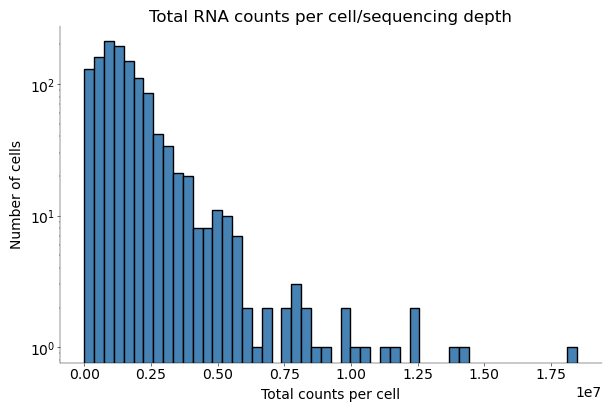

Number of expressed genes per cell: min = 1202, max = 18118, median = 7104, mean = 7136


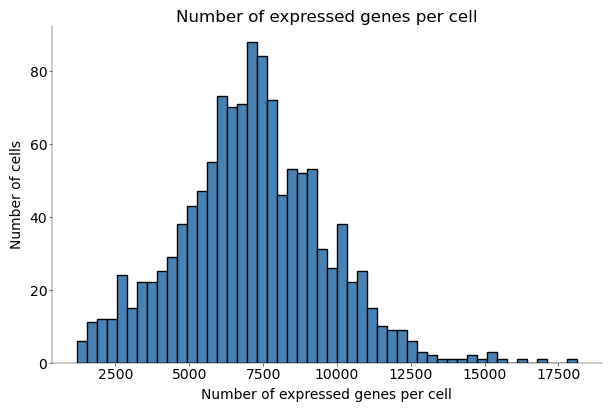

Mean counts per gene: min = 0.00, max = 48891.41, median = 0.49, mean = 39.78
Variance per gene: min = 0.00, max = 7830309032.40, median = 32.35, mean = 380392.38


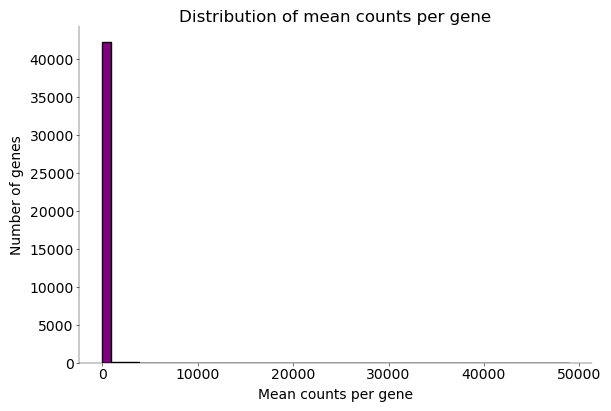

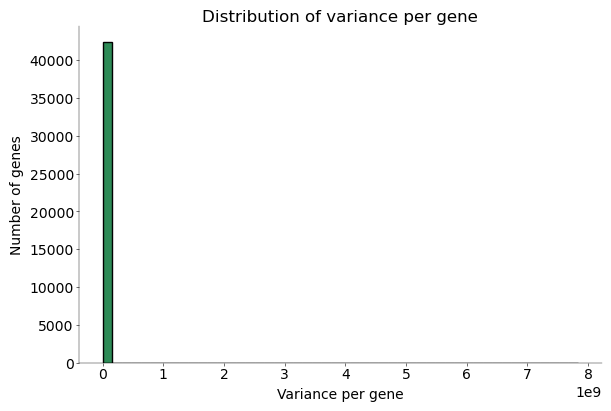

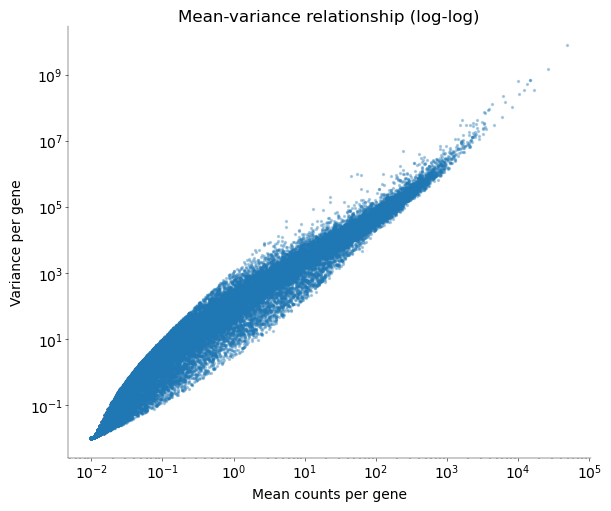

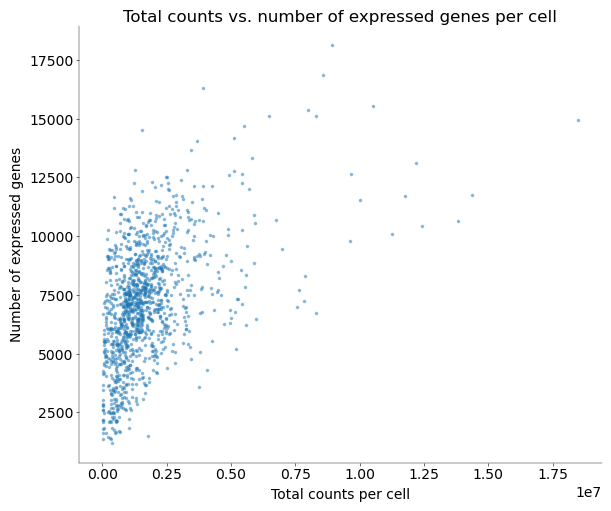

Cells with <2000000 total counts: 896
Cells with <3000 expressed genes: 70


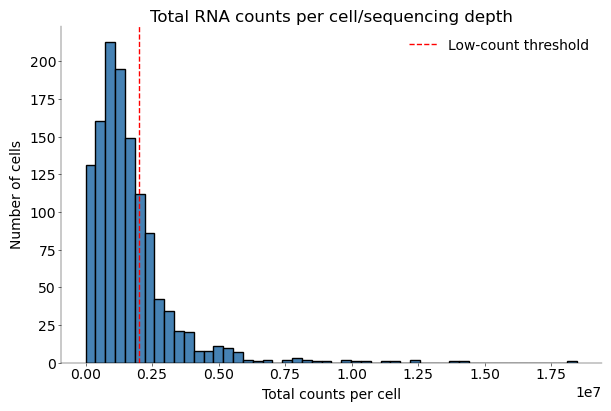

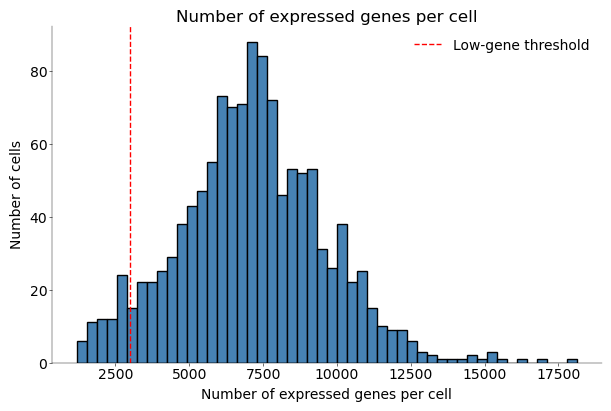

Pvalb found in genes array!
Sst found in genes array!
Vip found in genes array!
Snap25 found in genes array!
Slc17a7 found in genes array!
Gad2 found in genes array!


In [48]:
# 1. Total counts per cell
total_counts_per_cell = exonCounts.sum(axis=1)
print(
    "Total counts per cell: min = {:.0f}, max = {:.0f}, median = {:.0f}, mean = {:.0f}".format(
        total_counts_per_cell.min(),
        total_counts_per_cell.max(),
        np.median(total_counts_per_cell),
        total_counts_per_cell.mean(),
    )
)

plt.figure(figsize=(6, 4))
plt.hist(total_counts_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Total counts per cell")
plt.ylabel("Number of cells")
plt.title("Total RNA counts per cell/sequencing depth")
# Optionally, show on log-y to highlight outliers
plt.yscale("log")
plt.show()

# 2. Number of expressed genes per cell
num_genes_per_cell = (exonCounts > 0).sum(axis=1)
print(
    "Number of expressed genes per cell: min = {}, max = {}, median = {}, mean = {:.0f}".format(
        num_genes_per_cell.min(),
        num_genes_per_cell.max(),
        int(np.median(num_genes_per_cell)),
        num_genes_per_cell.mean(),
    )
)

plt.figure(figsize=(6, 4))
plt.hist(num_genes_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.xlabel("Number of expressed genes per cell")
plt.ylabel("Number of cells")
plt.title("Number of expressed genes per cell")
plt.show()

# 3. Mean and variance per gene
mean_counts_per_gene = exonCounts.mean(axis=0)
var_counts_per_gene = exonCounts.var(axis=0)
print(
    "Mean counts per gene: min = {:.2f}, max = {:.2f}, median = {:.2f}, mean = {:.2f}".format(
        mean_counts_per_gene.min(),
        mean_counts_per_gene.max(),
        np.median(mean_counts_per_gene),
        mean_counts_per_gene.mean(),
    )
)
print(
    "Variance per gene: min = {:.2f}, max = {:.2f}, median = {:.2f}, mean = {:.2f}".format(
        var_counts_per_gene.min(),
        var_counts_per_gene.max(),
        np.median(var_counts_per_gene),
        var_counts_per_gene.mean(),
    )
)

plt.figure(figsize=(6, 4))
plt.hist(mean_counts_per_gene, bins=50, color="purple", edgecolor="k")
plt.xlabel("Mean counts per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of mean counts per gene")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(var_counts_per_gene, bins=50, color="seagreen", edgecolor="k")
plt.xlabel("Variance per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of variance per gene")
plt.show()

# 4. Mean-variance relationship (log-log)
plt.figure(figsize=(6, 5))
plt.scatter(
    mean_counts_per_gene + 1e-2, var_counts_per_gene + 1e-2, alpha=0.3, s=8
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mean counts per gene")
plt.ylabel("Variance per gene")
plt.title("Mean-variance relationship (log-log)")
plt.show()

# 5. Scatter: total counts vs. number of expressed genes (per cell)
plt.figure(figsize=(6, 5))
plt.scatter(total_counts_per_cell, num_genes_per_cell, alpha=0.4, s=10)
plt.xlabel("Total counts per cell")
plt.ylabel("Number of expressed genes")
plt.title("Total counts vs. number of expressed genes per cell")
plt.show()

# Optional: flag possible outliers for further inspection (for example, cells with very low total counts or genes)
low_counts_threshold = 2e6  # Example threshold, adjust for your data!
low_genes_threshold = 3000  # Example threshold, adjust as needed

n_low_counts = np.sum(total_counts_per_cell < low_counts_threshold)
n_low_genes = np.sum(num_genes_per_cell < low_genes_threshold)
print(f"Cells with <{low_counts_threshold:.0f} total counts: {n_low_counts}")
print(f"Cells with <{low_genes_threshold} expressed genes: {n_low_genes}")

# (Optional) mark thresholds on plots:
plt.figure(figsize=(6, 4))
plt.hist(total_counts_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.axvline(
    low_counts_threshold,
    color="red",
    linestyle="dashed",
    label="Low-count threshold",
)
plt.xlabel("Total counts per cell")
plt.ylabel("Number of cells")
plt.title("Total RNA counts per cell/sequencing depth")
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(num_genes_per_cell, bins=50, color="steelblue", edgecolor="k")
plt.axvline(
    low_genes_threshold,
    color="red",
    linestyle="dashed",
    label="Low-gene threshold",
)
plt.xlabel("Number of expressed genes per cell")
plt.ylabel("Number of cells")
plt.title("Number of expressed genes per cell")
plt.legend()
plt.show()

# Print available marker genes (as before)
marker_genes = ["Pvalb", "Sst", "Vip", "Snap25", "Slc17a7", "Gad2"]
for g in marker_genes:
    if g in genes:
        print(f"{g} found in genes array!")

1. Total RNA counts per cell

- The distribution is right-skewed (long tail), which is normal for single-cell RNA-seq.
- Most cells have between 0.5M and 2M total counts.
- There are a few cells with much higher sequencing depth (“outliers”), but a large number of cells are below 2M total counts.

2. Number of expressed genes per cell

- Most cells have between 4,000 and 10,000 expressed genes, with a median of ~7,100.
- The lower tail (cells with <3,000 expressed genes) is quite small (70 cells).
- This distribution is also typical; higher sequencing depth leads to more detected genes.

3. Mean/variance per gene

- Most genes are expressed at very low levels (median mean count ~0.5).
- A few genes have much higher expression.
- Variance is strongly overdispersed compared to mean, which is expected for single-cell data and reflects biological and technical noise.

4. Mean-variance relationship

- The log-log plot shows a strong positive trend: variance increases faster than mean, confirming overdispersion.

5. QC thresholds

- Cells with very low total counts or very low detected genes are likely to be low-quality/damaged cells, or empty droplets in droplet-based protocols.
- Common practice: Filter out cells with total counts and/or expressed genes below a threshold.

6. Recommended filters based on your distributions:

- Cells with < 2,000,000 total counts:
This is a conservative threshold; most high-quality single-cell datasets set a lower limit of ~1M or less, but with Smart-seq/patch-seq, your median is much higher, so this is safe.
If you want to be less stringent (i.e., keep more cells), consider lowering to 1M or even 500,000, but check that you are not keeping a “low-quality” cluster in the low tail.
- Cells with < 3,000 detected genes:
Standard lower limit for “complexity.” These are likely broken/dying cells.
(Optional) Cells with extremely high total counts or detected genes can be flagged as potential doublets, but only if you see obvious outliers—yours don’t look excessive.

Cells retained after all filtering: 791 / 1232


/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/727147550.py:90: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


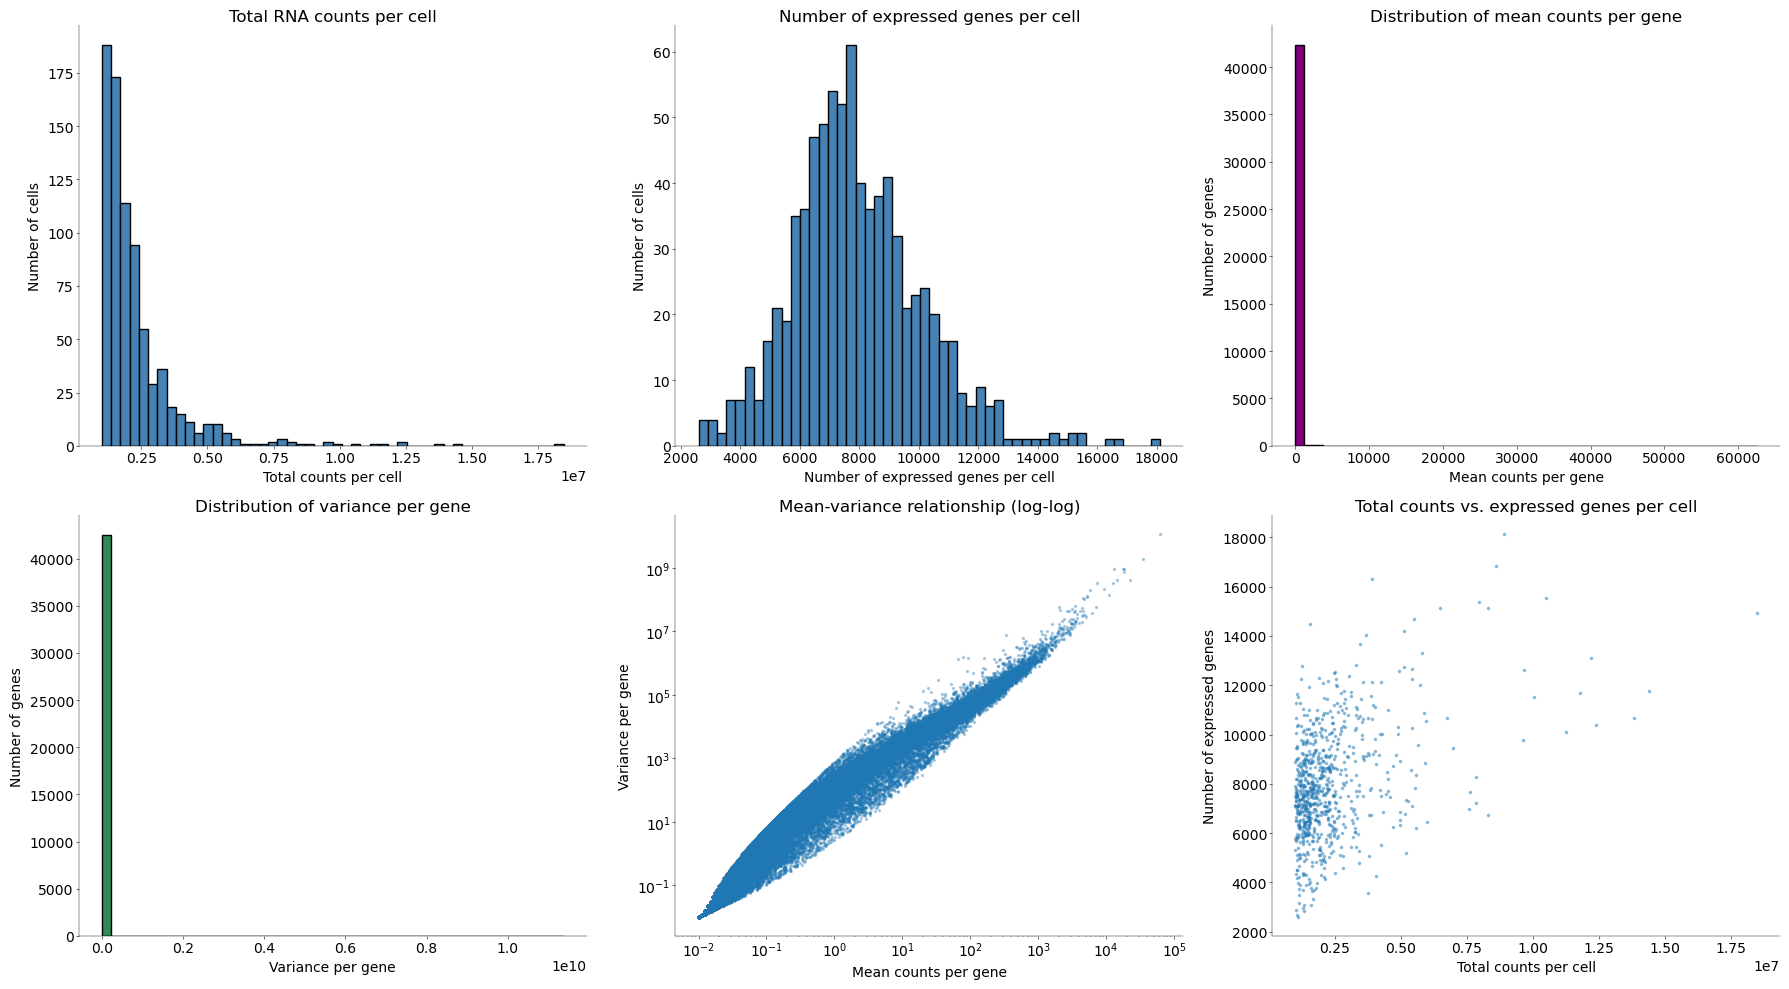

In [49]:
# 0. Apply exclude_low_quality to meta and metadata if not done yet
if len(meta) == 1329:  # Only filter if not already filtered
    meta_rna = meta[exclude_low_quality].reset_index(drop=True)
    # rna_family_rna = np.array(rna_family)[exclude_low_quality]
    # rna_type_rna = np.array(rna_type)[exclude_low_quality]
    # ... any other cell-level arrays
else:
    meta_rna = meta  # Already filtered

# 1. Use exonCounts, meta_rna (both should be length 1232)
assert exonCounts.shape[0] == len(
    meta_rna
), "Mismatch: exonCounts and meta_rna not aligned!"

# 2. Compute QC stats
total_counts_per_cell = exonCounts.sum(axis=1)
num_genes_per_cell = (exonCounts > 0).sum(axis=1)

# 3. Filter cells by QC
cell_filter = (total_counts_per_cell >= 1_000_000) & (
    num_genes_per_cell >= 2500
)
print(
    f"Cells retained after all filtering: {cell_filter.sum()} / {len(cell_filter)}"
)

# 4. Apply filter to everything (all now length 1232)
meta_filt = meta_rna.loc[cell_filter].reset_index(drop=True)
exonCounts_filt = exonCounts[cell_filter, :]
# rna_family_filt = rna_family_rna[cell_filter]
# rna_type_filt = rna_type_rna[cell_filter]
# etc.

# 5. Recompute stats on filtered data
total_counts_per_cell_filt = exonCounts_filt.sum(axis=1)
num_genes_per_cell_filt = (exonCounts_filt > 0).sum(axis=1)
mean_counts_per_gene_filt = exonCounts_filt.mean(axis=0)
var_counts_per_gene_filt = exonCounts_filt.var(axis=0)

# 6. Plot all QC plots in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].hist(
    total_counts_per_cell_filt, bins=50, color="steelblue", edgecolor="k"
)
axs[0, 0].set_xlabel("Total counts per cell")
axs[0, 0].set_ylabel("Number of cells")
axs[0, 0].set_title("Total RNA counts per cell")

axs[0, 1].hist(
    num_genes_per_cell_filt, bins=50, color="steelblue", edgecolor="k"
)
axs[0, 1].set_xlabel("Number of expressed genes per cell")
axs[0, 1].set_ylabel("Number of cells")
axs[0, 1].set_title("Number of expressed genes per cell")

axs[0, 2].hist(
    mean_counts_per_gene_filt, bins=50, color="purple", edgecolor="k"
)
axs[0, 2].set_xlabel("Mean counts per gene")
axs[0, 2].set_ylabel("Number of genes")
axs[0, 2].set_title("Distribution of mean counts per gene")

axs[1, 0].hist(
    var_counts_per_gene_filt, bins=50, color="seagreen", edgecolor="k"
)
axs[1, 0].set_xlabel("Variance per gene")
axs[1, 0].set_ylabel("Number of genes")
axs[1, 0].set_title("Distribution of variance per gene")

axs[1, 1].scatter(
    mean_counts_per_gene_filt + 1e-2,
    var_counts_per_gene_filt + 1e-2,
    alpha=0.3,
    s=8,
)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Mean counts per gene")
axs[1, 1].set_ylabel("Variance per gene")
axs[1, 1].set_title("Mean-variance relationship (log-log)")

axs[1, 2].scatter(
    total_counts_per_cell_filt, num_genes_per_cell_filt, alpha=0.4, s=10
)
axs[1, 2].set_xlabel("Total counts per cell")
axs[1, 2].set_ylabel("Number of expressed genes")
axs[1, 2].set_title("Total counts vs. expressed genes per cell")

plt.tight_layout()
plt.show()

Chato:
“We set quality control thresholds based on inspection of the distributions: cells with fewer than 1,000,000 total counts or fewer than 2,500 detected genes were excluded, resulting in 791 high-quality cells for downstream analysis. These thresholds balance removal of low-complexity cells with retention of biological diversity, and are in line with best practices for Patch-seq data (Luecken & Theis 2019).”

what is missing:
- Compare Marker Gene Expression Across Major Families
- For each major family (e.g., Sst, Pvalb, Vip, Lamp5, excitatory), plot its marker gene in that family and others.
- Show that expression is family-specific.

Similarly, you can compute and plot statistics over the electrophyiological data. Also, investigate the distribution of "ground truth" labels. Comment about other relevant metadata, and think if you can use it as some external validation for other analyses. If you do use other metadata throughout the project, explain why and what you get out of it. Take into account that certain features may not be very informative for our purposes (e.g. mouse age), so only choose features that provide you with useful information in this context. If you want to get additional information about the metadata, have a look at the extended data section in the original publication (e.g., cre-lines in Figure 1c in the extended data).

electrophysiological features

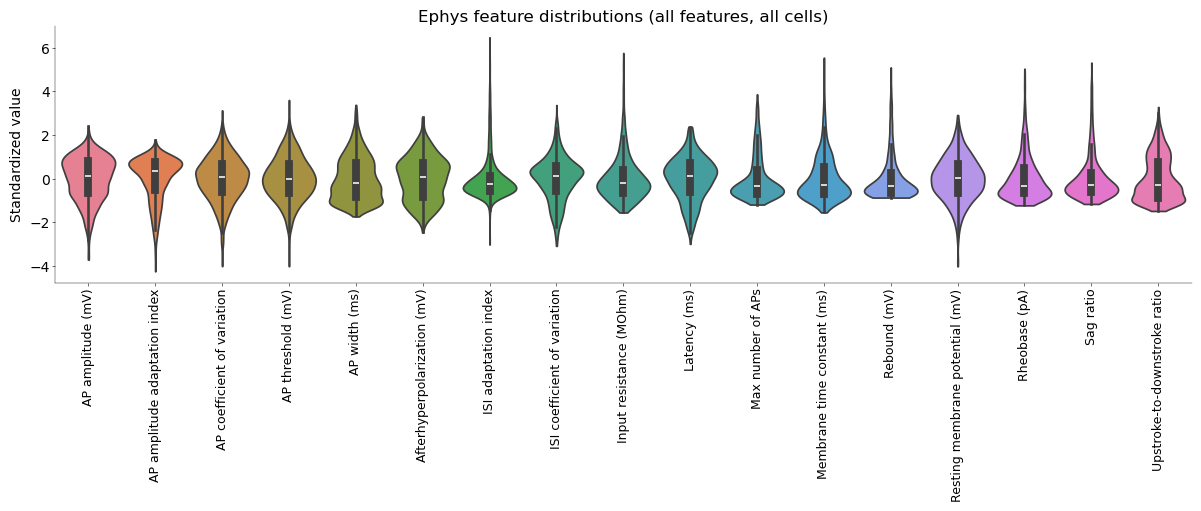

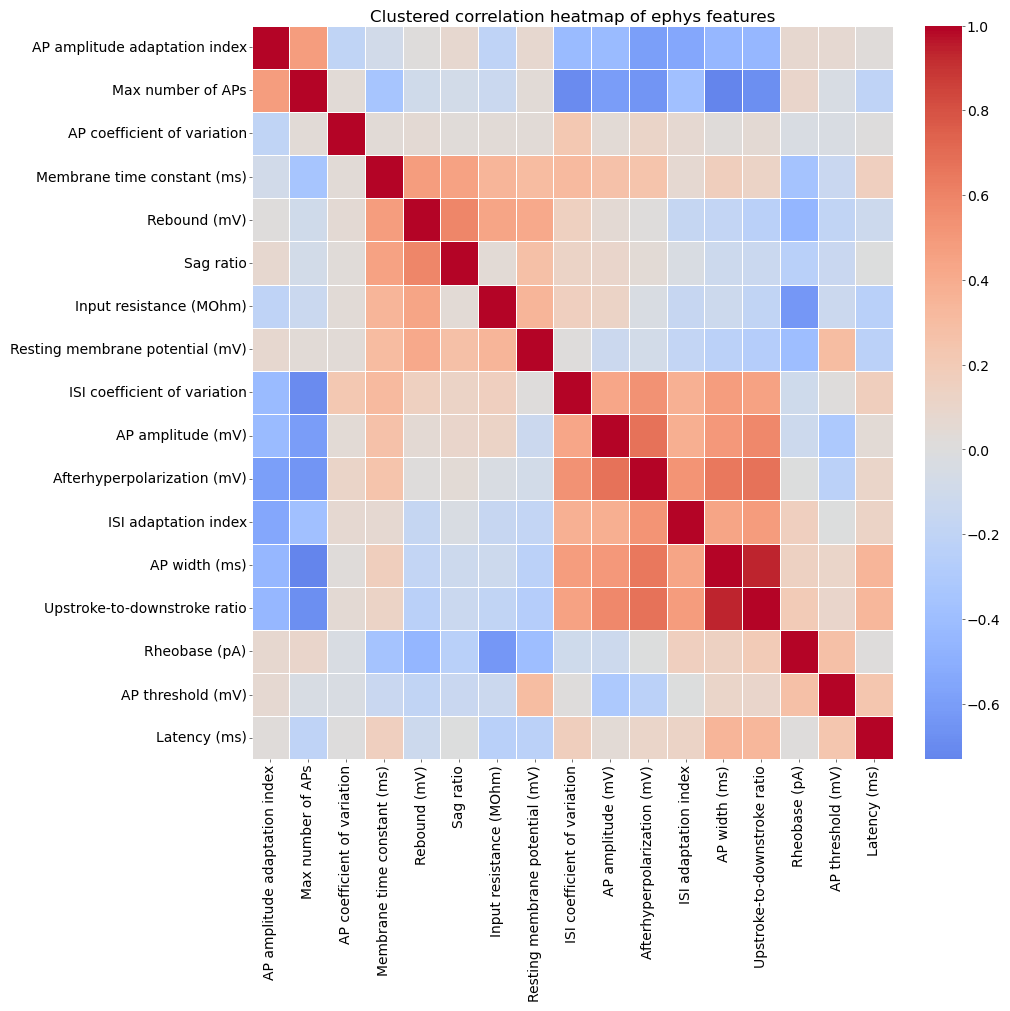


Strongly correlated feature pairs (|r| > 0.5):
                    Feature 1                    Feature 2  Correlation
                AP width (ms) Upstroke-to-downstroke ratio     0.937448
                AP width (ms)            Max number of APs    -0.731293
 ISI coefficient of variation            Max number of APs    -0.697156
            Max number of APs Upstroke-to-downstroke ratio    -0.680011
  Afterhyperpolarization (mV) Upstroke-to-downstroke ratio     0.669955
            AP amplitude (mV)  Afterhyperpolarization (mV)     0.668830
                AP width (ms)  Afterhyperpolarization (mV)     0.650019
  Afterhyperpolarization (mV)            Max number of APs    -0.648270
      Input resistance (MOhm)                Rheobase (pA)    -0.633236
            AP amplitude (mV)            Max number of APs    -0.600405
AP amplitude adaptation index  Afterhyperpolarization (mV)    -0.594769
                 Rebound (mV)                    Sag ratio     0.594195
            AP a

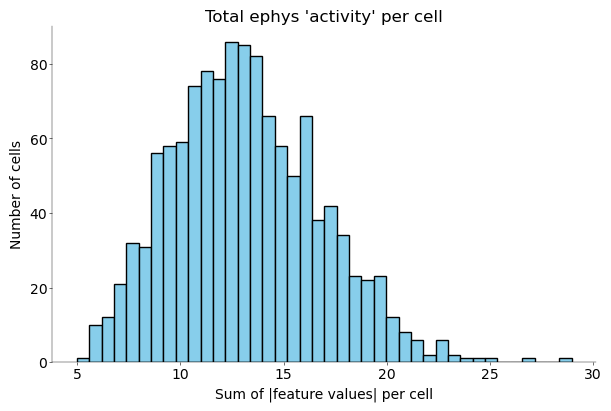

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2757669603.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


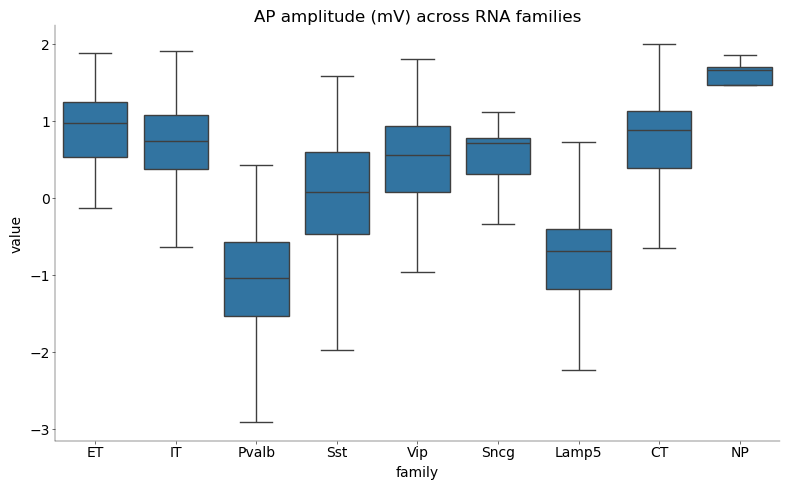

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2757669603.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


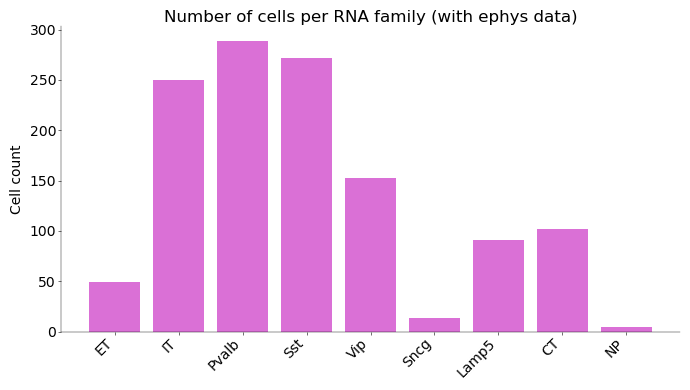

In [50]:
from scipy.cluster.hierarchy import linkage, leaves_list

# 1. Prepare DataFrame for plotting/correlation (after all filtering)
df_ephys = pd.DataFrame(ephysData_filtered, columns=ephysNames_filtered)

# 2. Violin plot: distributions of all features, all cells
plt.figure(figsize=(max(10, len(ephysNames_filtered) * 0.7), 5))
sns.violinplot(data=df_ephys, cut=0)
plt.xticks(rotation=90, fontsize=9)
plt.ylabel("Standardized value")
plt.title("Ephys feature distributions (all features, all cells)")
plt.show()

# 3. Feature-feature correlation matrix and clustering
corr_matrix = df_ephys.corr()
order = leaves_list(linkage(corr_matrix, method="average"))
ordered_corr = corr_matrix.values[order][:, order]
ordered_labels = corr_matrix.columns[order]

plt.figure(figsize=(10, 10))
sns.heatmap(
    ordered_corr,
    xticklabels=ordered_labels,
    yticklabels=ordered_labels,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
)
plt.title("Clustered correlation heatmap of ephys features")
plt.show()

# 4. Find and print strong correlations
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
threshold = 0.5
strong_corr = corr_pairs[np.abs(corr_pairs["Correlation"]) > threshold]
print("\nStrongly correlated feature pairs (|r| > 0.5):")
print(
    strong_corr.sort_values(
        by="Correlation", key=np.abs, ascending=False
    ).to_string(index=False)
)

# 5. "Activity" per cell: sum of absolute feature values (optional outlier check)
cell_activity = np.sum(np.abs(ephysData_filtered), axis=1)
plt.figure(figsize=(6, 4))
plt.hist(cell_activity, bins=40, color="skyblue", edgecolor="k")
plt.xlabel("Sum of |feature values| per cell")
plt.ylabel("Number of cells")
plt.title("Total ephys 'activity' per cell")
plt.show()

# 6. Compare a key feature across RNA families (make sure to filter rna_family)
key_feature = "AP amplitude (mV)"
if key_feature in ephysNames_filtered:
    idx = np.where(ephysNames_filtered == key_feature)[0][0]

    # rna_family is already meta["RNA family"][exclude_low_quality], length matches keepcells
    rna_family_rna = np.array(
        rna_family
    )  # length == exonCounts.shape[0] == 1232
    rna_family_filtered = rna_family_rna[
        keepcells
    ]  # now length matches ephysData_filtered

    data = pd.DataFrame(
        {
            "value": ephysData_filtered[:, idx],
            "family": rna_family_filtered,
        }
    )

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="family", y="value", data=data, showfliers=False)
    plt.title(f"{key_feature} across RNA families")
    plt.tight_layout()
    plt.show()


# 7. Barplot: number of cells per RNA family (with ephys data)
from collections import Counter

family_counts = Counter(rna_family_filtered)
plt.figure(figsize=(7, 4))
plt.bar(family_counts.keys(), family_counts.values(), color="orchid")
plt.xticks(rotation=45, ha="right")
plt.title("Number of cells per RNA family (with ephys data)")
plt.ylabel("Cell count")
plt.tight_layout()
plt.show()

META DATA PLOTS

In [51]:
# Filter meta columns to only good cells (RNA + ephys)
meta_rna = meta[exclude_low_quality].reset_index(drop=True)
meta_filtered = meta_rna.loc[keepcells].reset_index(drop=True)

for i, name in enumerate(ephysNames_filtered):
    meta_filtered[name] = ephysData_filtered[:, i]

# Now meta_filtered is the right shape for all your downstream plots (n_cells, ...)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/339708939.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


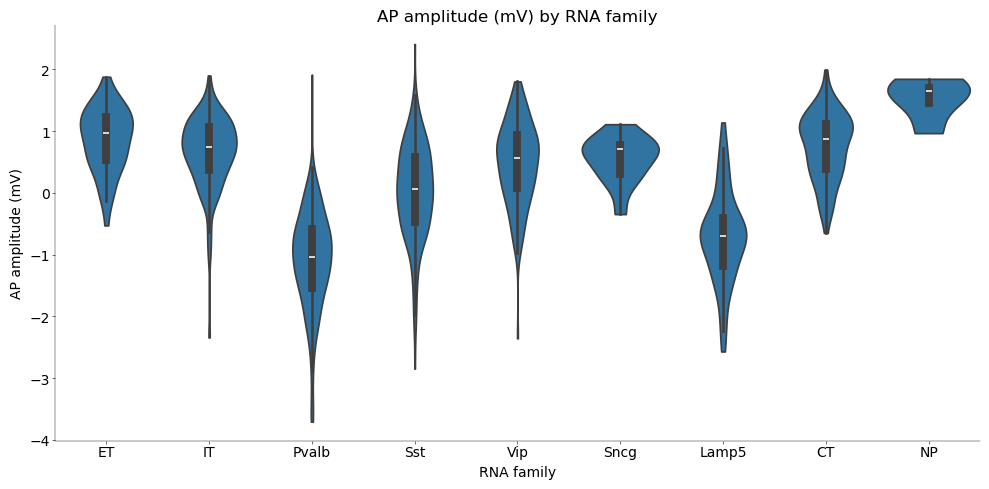

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/339708939.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


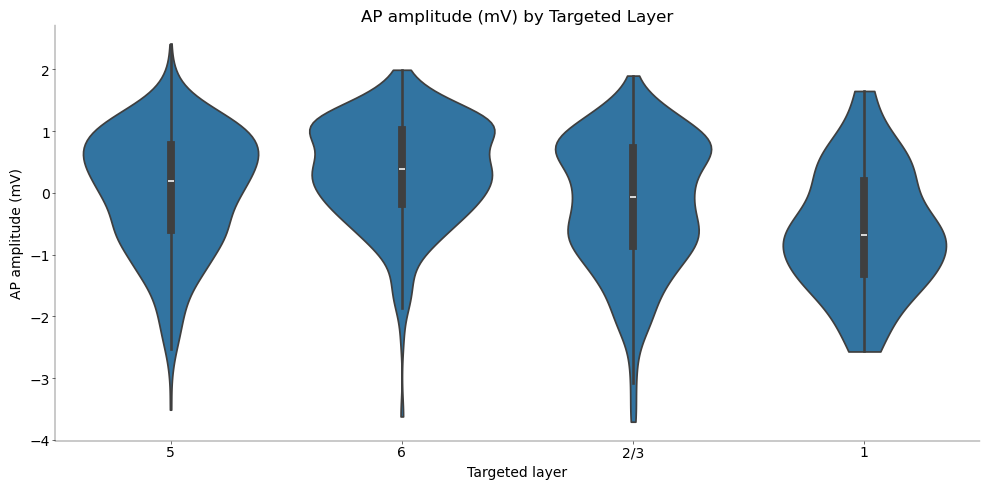

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/339708939.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


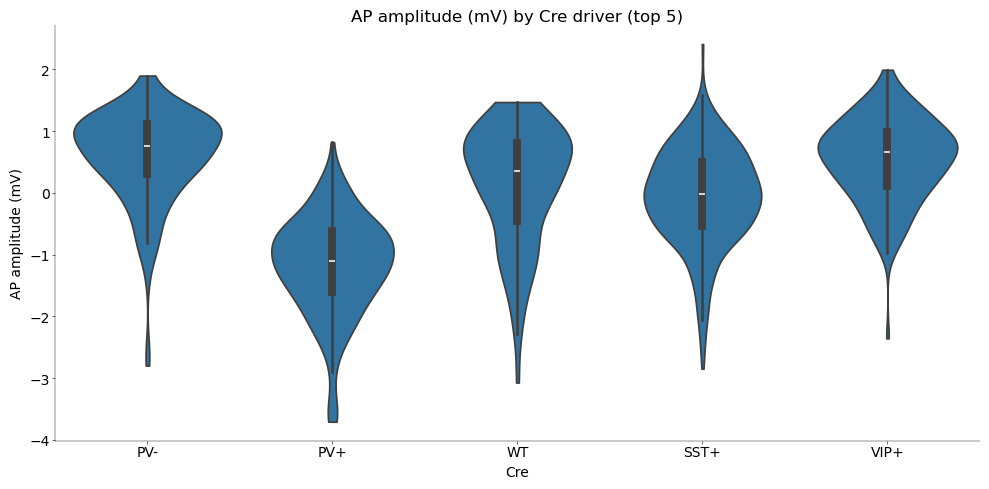

In [52]:
#  Violin plots for features by RNA family, RNA type, Layer, and Cre
df_ephys = pd.DataFrame(ephysData_filtered, columns=ephysNames_filtered)

# Add filtered metadata columns to your DataFrame for easy plotting
df_ephys["RNA family"] = meta_filtered["RNA family"].values
df_ephys["RNA type"] = meta_filtered["RNA type"].values
df_ephys["Targeted layer"] = meta_filtered["Targeted layer"].values
df_ephys["Cre"] = meta_filtered["Cre"].values

# RNA family example
plt.figure(figsize=(10, 5))
sns.violinplot(x="RNA family", y="AP amplitude (mV)", data=df_ephys, cut=0)
plt.title("AP amplitude (mV) by RNA family")
plt.tight_layout()
plt.show()

# Targeted layer example (filter for common layers only)
top_layers = df_ephys["Targeted layer"].value_counts().index[:6]
df_layer = df_ephys[df_ephys["Targeted layer"].isin(top_layers)]
plt.figure(figsize=(10, 5))
sns.violinplot(x="Targeted layer", y="AP amplitude (mV)", data=df_layer, cut=0)
plt.title("AP amplitude (mV) by Targeted Layer")
plt.tight_layout()
plt.show()

# Cre line (filter for top 5 most frequent Cre)
top_cres = df_ephys["Cre"].value_counts().index[:5]
df_cre = df_ephys[df_ephys["Cre"].isin(top_cres)]
plt.figure(figsize=(10, 5))
sns.violinplot(x="Cre", y="AP amplitude (mV)", data=df_cre, cut=0)
plt.title("AP amplitude (mV) by Cre driver (top 5)")
plt.tight_layout()
plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2748560109.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


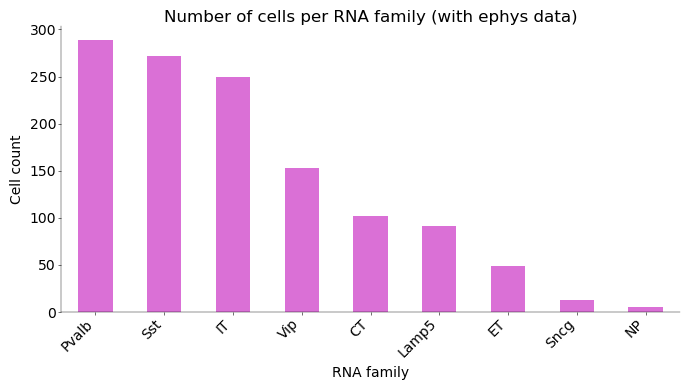

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2748560109.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


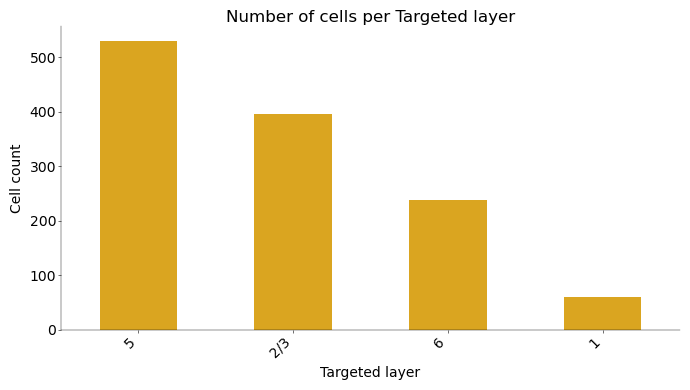

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2748560109.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


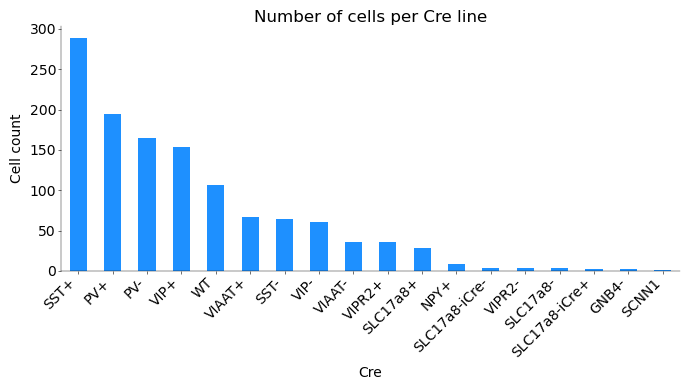

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/2748560109.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


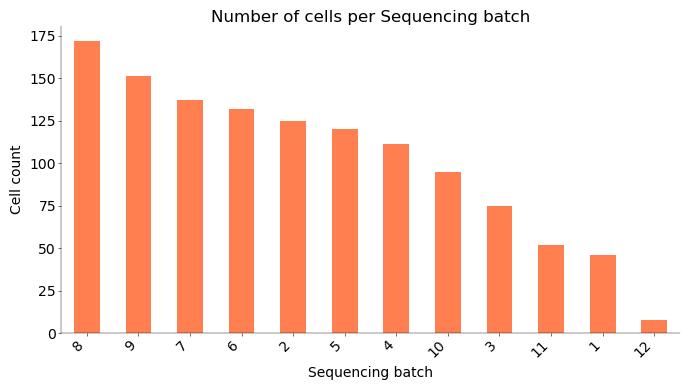

In [53]:
# Barplots for category distribution (RNA family, layer, Cre, batch)
# RNA family distribution
plt.figure(figsize=(7, 4))
df_ephys["RNA family"].value_counts().plot(kind="bar", color="orchid")
plt.title("Number of cells per RNA family (with ephys data)")
plt.ylabel("Cell count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Targeted layer distribution
plt.figure(figsize=(7, 4))
df_ephys["Targeted layer"].value_counts().plot(kind="bar", color="goldenrod")
plt.title("Number of cells per Targeted layer")
plt.ylabel("Cell count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Cre line distribution
plt.figure(figsize=(7, 4))
df_ephys["Cre"].value_counts().plot(kind="bar", color="dodgerblue")
plt.title("Number of cells per Cre line")
plt.ylabel("Cell count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Sequencing batch (if you suspect batch effects)
plt.figure(figsize=(7, 4))
meta_filtered["Sequencing batch"].value_counts().plot(
    kind="bar", color="coral"
)
plt.title("Number of cells per Sequencing batch")
plt.ylabel("Cell count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3426823715.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


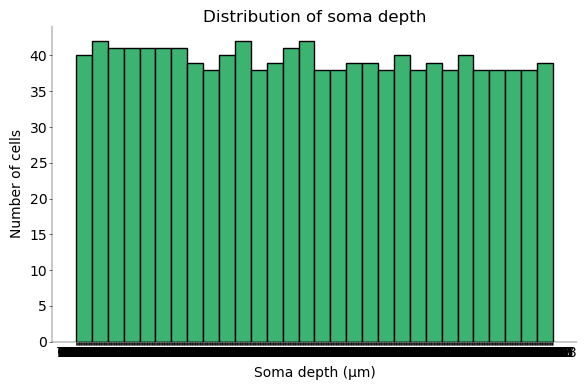

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3426823715.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


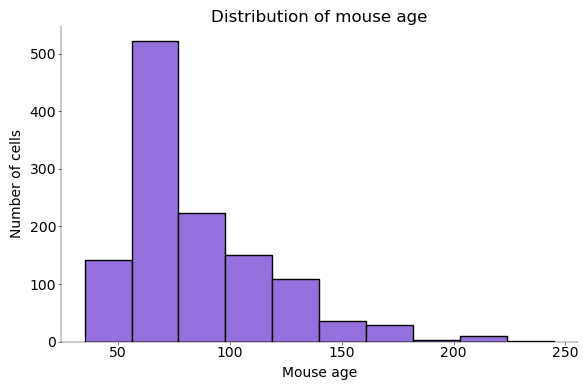

In [54]:
# Soma depth (µm)
plt.figure(figsize=(6, 4))
plt.hist(
    meta_filtered["Soma depth (µm)"].dropna(),
    bins=30,
    color="mediumseagreen",
    edgecolor="k",
)
plt.xlabel("Soma depth (µm)")
plt.ylabel("Number of cells")
plt.title("Distribution of soma depth")
plt.tight_layout()
plt.show()

# Mouse age (if numeric)
if meta_filtered["Mouse age"].dtype != object:
    plt.figure(figsize=(6, 4))
    plt.hist(
        meta_filtered["Mouse age"].dropna(),
        bins=10,
        color="mediumpurple",
        edgecolor="k",
    )
    plt.xlabel("Mouse age")
    plt.ylabel("Number of cells")
    plt.title("Distribution of mouse age")
    plt.tight_layout()
    plt.show()

In [55]:
summary = df_ephys.groupby("RNA family")[ephysNames_filtered].agg(
    ["mean", "std"]
)
print(summary)

           AP amplitude (mV)           AP amplitude adaptation index  \
                        mean       std                          mean   
RNA family                                                             
CT                  0.750804  0.539526                     -0.082046   
ET                  0.861882  0.514215                     -0.388679   
IT                  0.655190  0.587139                     -0.637653   
Lamp5              -0.714630  0.734239                      0.181042   
NP                  1.525427  0.340939                     -0.794056   
Pvalb              -1.082365  0.786206                      0.722903   
Sncg                0.552985  0.377340                     -0.032253   
Sst                 0.026163  0.773124                      0.453457   
Vip                 0.479023  0.669914                     -1.029526   

                     AP coefficient of variation           AP threshold (mV)  \
                 std                        mean       

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


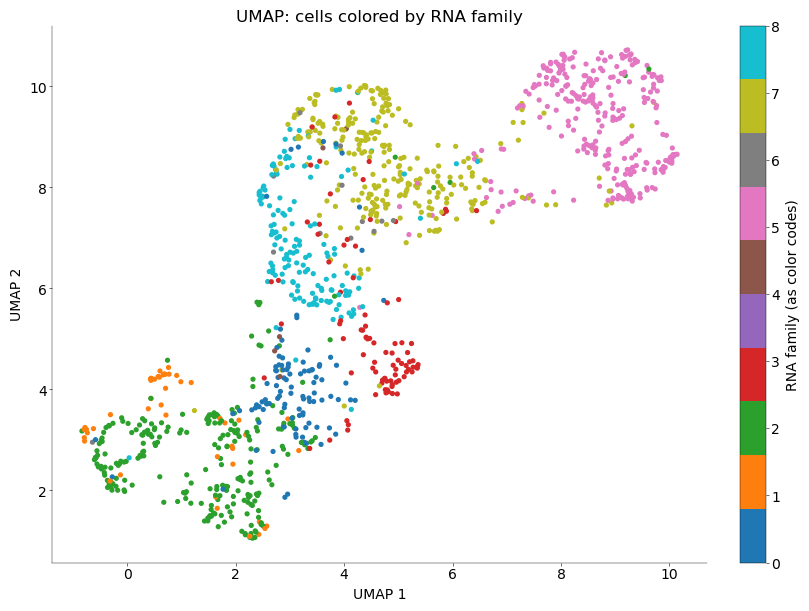

In [56]:
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(ephysData_filtered)
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=pd.Categorical(df_ephys["RNA family"]).codes,
    cmap="tab10",
    s=30,
)
plt.colorbar(label="RNA family (as color codes)")
plt.title("UMAP: cells colored by RNA family")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

1. Violin/Box Plots: AP Amplitude and Other Features

- AP amplitude (mV) by RNA family
Interpretation:
Pvalb and Lamp5 families have lower (even negative, since standardized) AP amplitude compared to other families.
NP family shows the highest standardized AP amplitude (mean ≈ +1.5), while CT, ET, IT, Vip, Sst, Sncg are generally intermediate.
Spread (std): Sst and Pvalb have large spreads, indicating more cell-to-cell diversity in AP amplitude within those types.
This suggests intrinsic physiological differences between transcriptomic types, and validates the biological meaning of the RNA family labels.
- AP amplitude (mV) by Targeted Layer
Interpretation:
Layers 5, 6, and 2/3 have similar distributions, with Layer 1 tending to have slightly lower mean AP amplitude.
Takeaway: Layer is a weaker separator than RNA family, but still shows some difference—could relate to cell types occupying those layers.
- AP amplitude (mV) by Cre driver
Interpretation:
Differences in AP amplitude map onto genetic targeting lines: PV+ and PV- mice show lower mean, while VIP+, SST+ are higher.
Takeaway: Genetic markers (Cre lines) do relate to ephys phenotype, supporting their use as “ground truth” or validation for cell classification.

2. Barplots: Counts per RNA family, Layer, Cre, Batch

RNA family: Pvalb, Sst, IT, Vip are the largest families. NP, Sncg, ET are rare—(keep in mind for downstream balanced analyses)
Targeted Layer: Layer 5 dominates, followed by 2/3 and 6. Layer 1 is much less sampled.
Cre line: SST+, PV+, VIP+ are frequent; many other Cre lines are rare.
Sequencing batch: Distribution is reasonably balanced, with no single batch dominating, but you should still check for batch effects later in dimensionality reduction.

3. Soma depth and Mouse age histograms

Soma depth: Very uniform, indicating good sampling throughout the cortex.
Mouse age: Most cells come from younger mice, with a long tail toward older ages.
Implication: Be aware of possible age effects, but unless you see ephys feature differences by age, probably not a confound.

4. Summary Table: Ephys Means/SDs by RNA Family

Characterizing cell types: You see that, e.g., Pvalb cells have:
- Lower AP amplitude and width (fast-spiking phenotype)
- Lower resting membrane potential (tend toward more negative values)
- Higher AP adaptation index (faster adaptation)
- Biological consistency: Matches known properties of interneurons (Pvalb) vs. excitatory types (IT, ET, CT).
Examples:

NP family: High AP amplitude, more depolarized resting membrane, low rheobase (fire easily).
Lamp5: Low AP amplitude, higher variability—likely a diverse set of interneurons.
Sst: Intermediate in many features, but higher rebound, matches known Sst cell traits.

5. UMAP Plot (remove axis ticks)
- Distinct clusters: You see multiple, well-separated groups in UMAP space, each corresponding to a different RNA family
- Minimal overlap
- Smooth transitions: Some clusters are more spread out or show “bridges,” which could reflect either real biological gradients (e.g., intermediate cell states) or technical noise—but with clear family separation, biology dominates
Class balance: Each cluster is populated (i.e., no cluster is just a few cells, except maybe rare types), which is good for downstream clustering or supervised analysis

Conclusion:
- metadata is highly informative: RNA family, layer, and Cre line all show meaningful ephys differences
- RNA family and Cre line can be used as “external validation” for clustering and classification
- Layer and batch: “nuisance variables”—they do have effect, but less than family/Cre

Electrophysiological features (e.g., AP amplitude) display marked differences across RNA families, Cre lines, and cortical layers. For example, Pvalb and Lamp5 families show lower mean AP amplitude, while NP and IT families are higher, consistent with known fast- and slow-spiking neuron identities. The distribution of cells across families and Cre lines is balanced enough for downstream analysis, though rare types are less well represented. These metadata can thus be used for external validation of unsupervised clustering or dimensionality reduction.

**2) Normalize & transform the data; select genes & apply PCA.** There are several ways of normalizing the RNA count data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data, but not for this read count data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization. After normalization and transformation, choose a set of highly variable genes (as demonstrated in the lecture) and apply PCA. Play with the number of selected genes and the number of PCA components, and again compare their effects on the two-dimensional visualization.

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


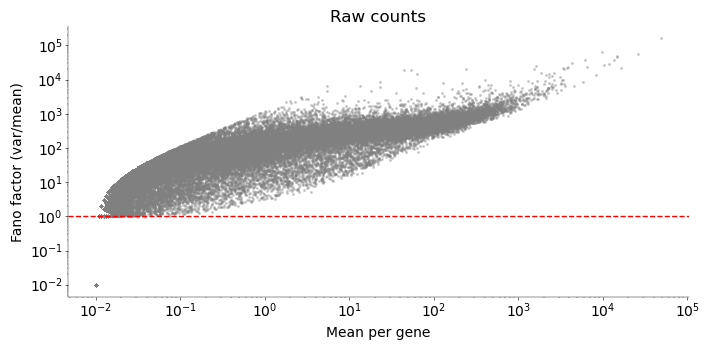

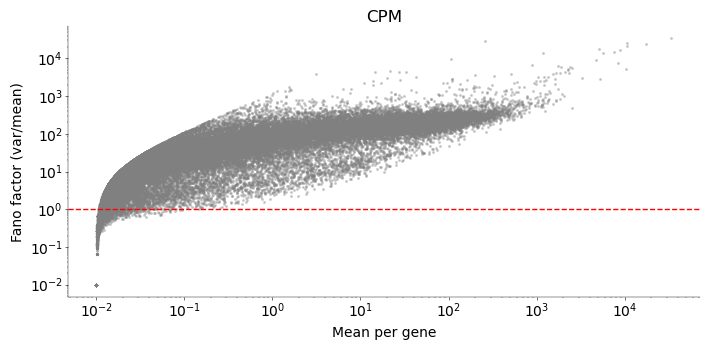

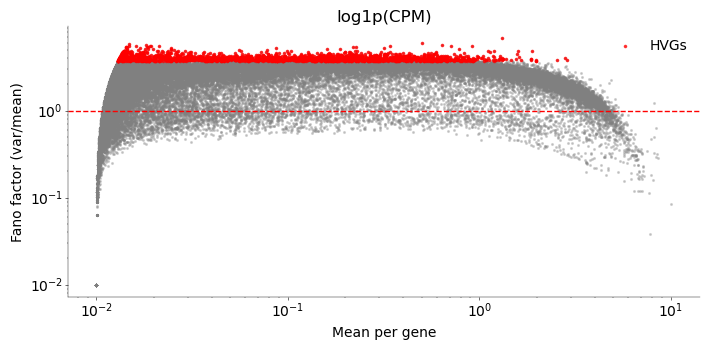

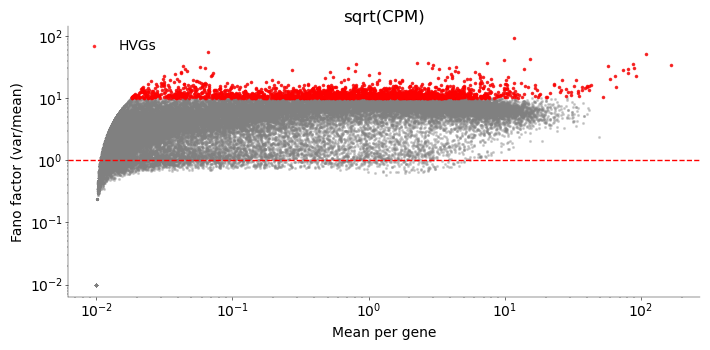

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:94: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


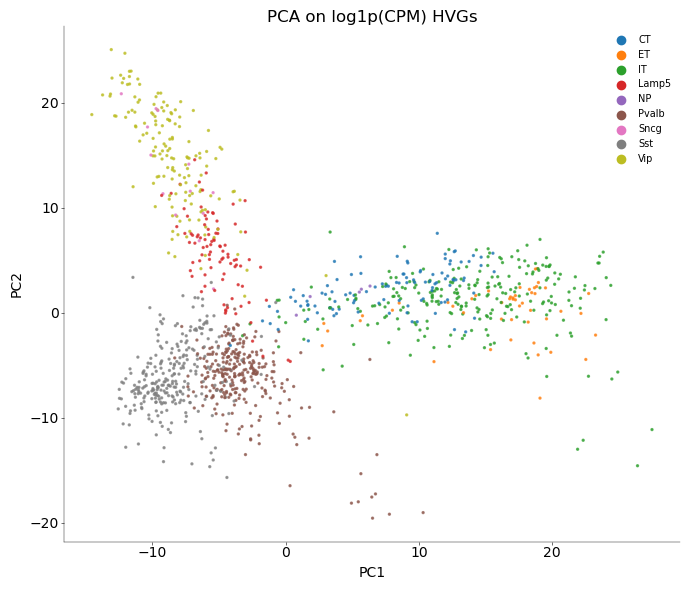

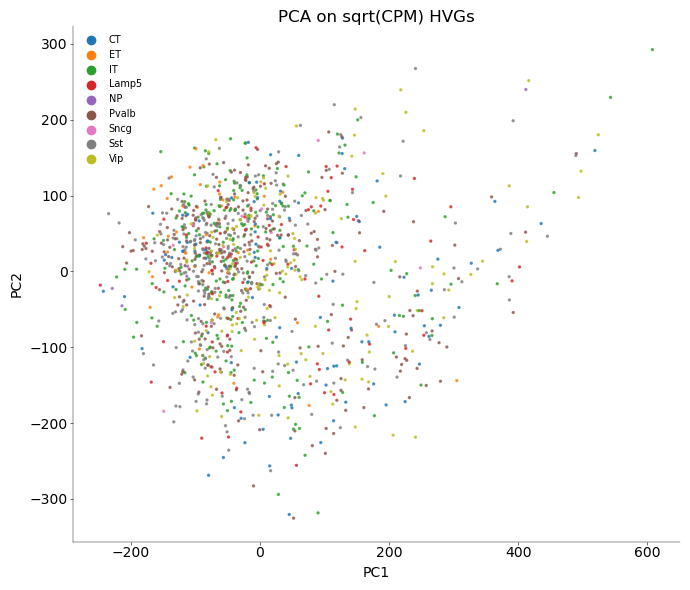

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:109: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


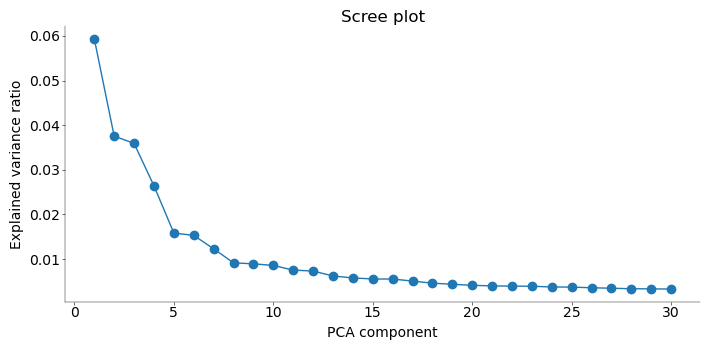

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:119: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


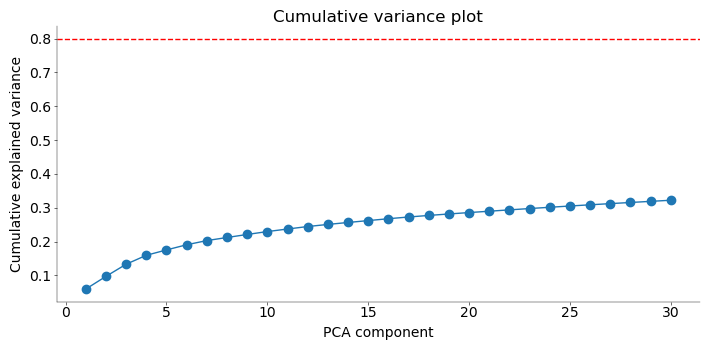

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:237: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.98])


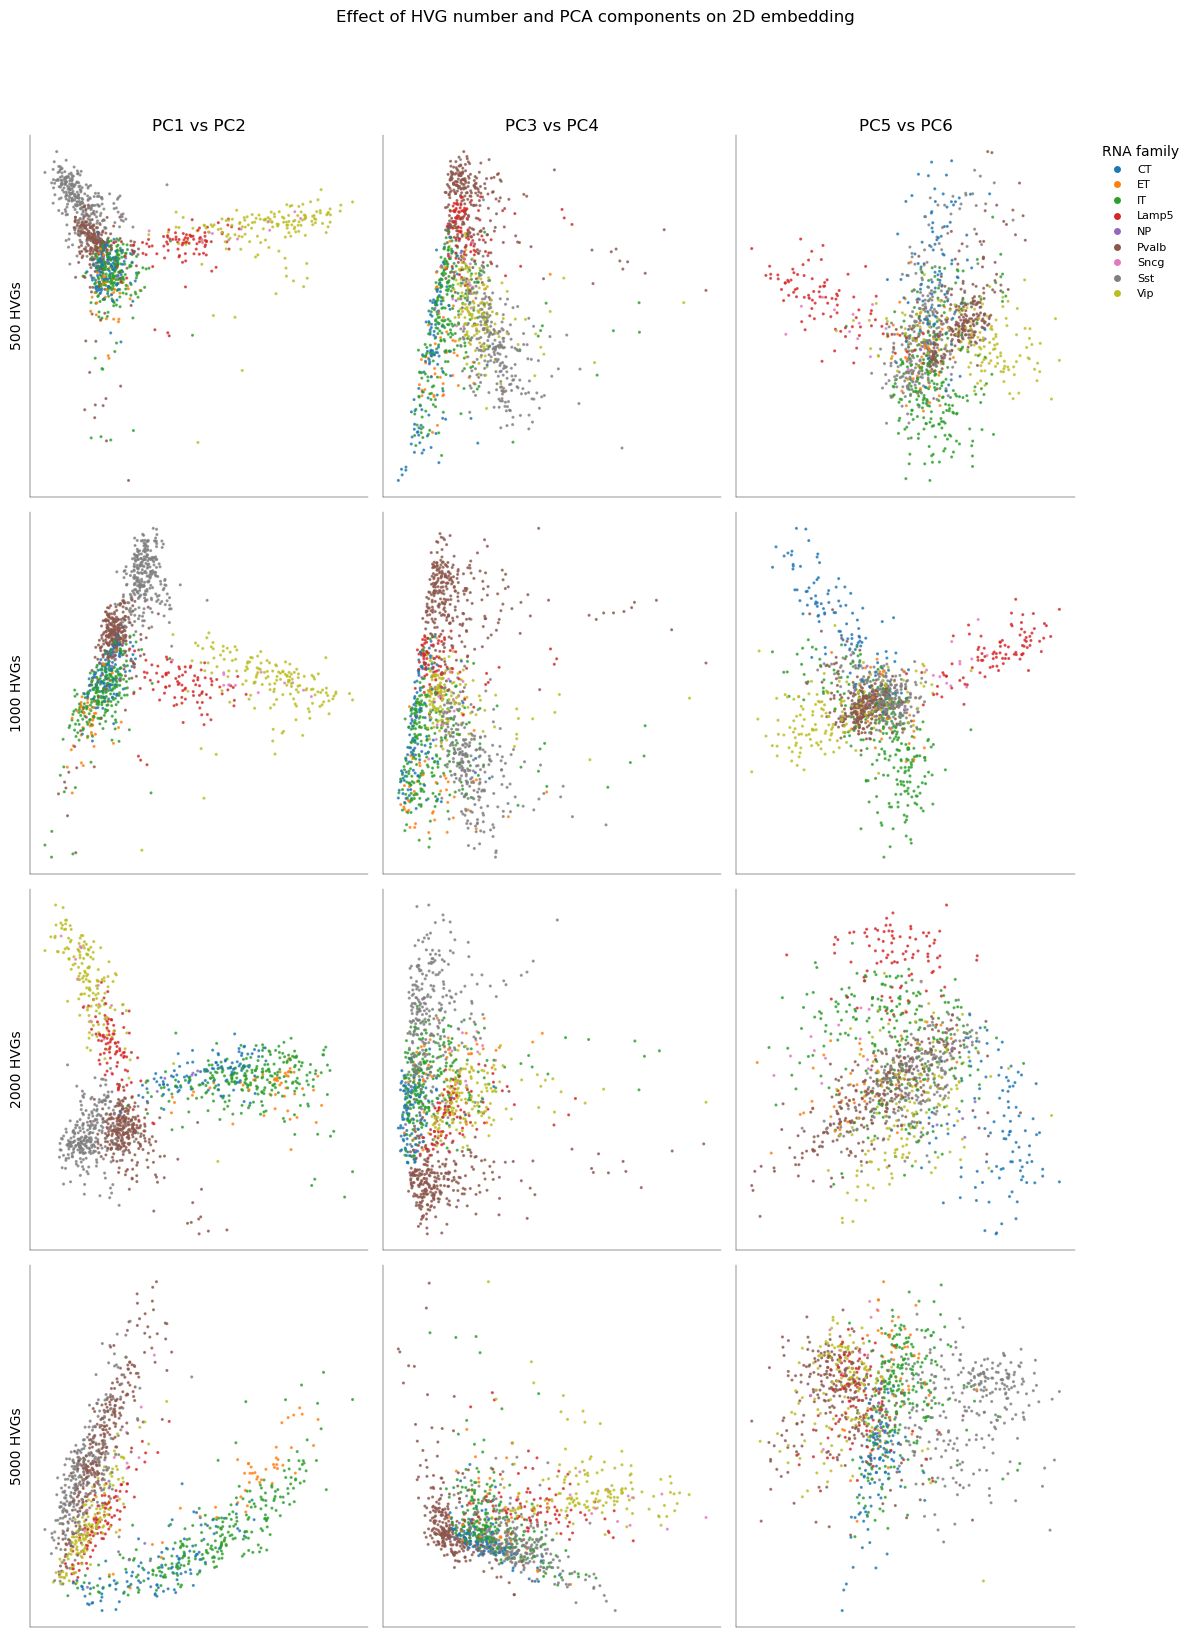

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3529790825.py:94: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


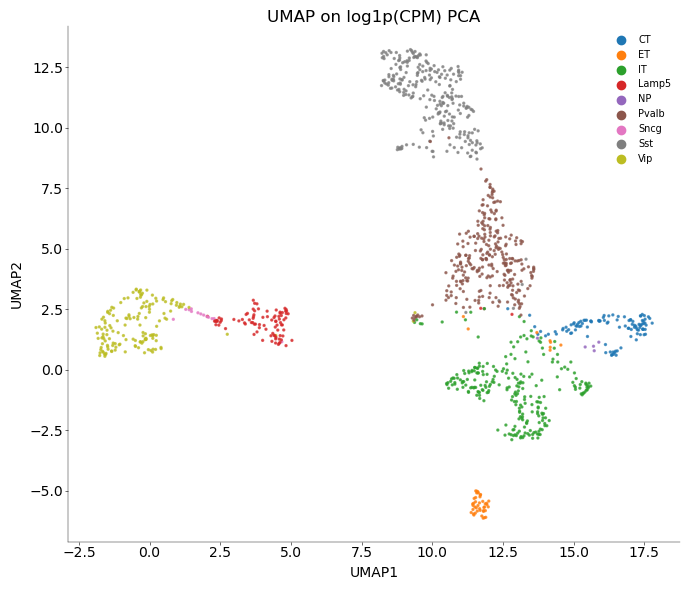

Silhouette score (PCA, top 10 PCs, RNA family): 0.17
Top 10 HVGs by log1p(CPM) dispersion:
['Gm36161' 'Col6a1' 'Gm6982' 'Pdyn' 'Cd69' 'Gm26942' 'Htr3a' 'Gm18248'
 'Tac2' 'Vip']


In [57]:
from sklearn.decomposition import PCA


# ----------- 1. Normalization Methods -----------
def normalize_cpm(counts):
    counts_per_cell = counts.sum(axis=1, keepdims=True)
    return counts / counts_per_cell * 1e6


def normalize_rpkm(counts, gene_lengths):
    counts_per_cell = counts.sum(axis=1, keepdims=True)
    rpk = counts / (gene_lengths / 1e3)  # gene_lengths in base pairs
    rpkm = rpk / (counts_per_cell / 1e6)
    return rpkm


# ----------- 2. Transformations -----------
def log1p_transform(X):
    return np.log1p(X)


def sqrt_transform(X):
    return np.sqrt(X)


# ----------- 3. HVG selection -----------
def select_hvgs(data, n_hvgs=2000, gene_names=None):
    # data: cells x genes, e.g. log1p(CPM)
    gene_means = data.mean(axis=0)
    gene_vars = data.var(axis=0)
    gene_disp = gene_vars / (gene_means + 1e-10)
    top_idx = np.argsort(gene_disp)[-n_hvgs:]
    hvg_names = gene_names[top_idx] if gene_names is not None else top_idx
    return top_idx, hvg_names, gene_disp


# ----------- 4. PCA -----------
def run_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data)
    return X_pca, pca


# ----------- 5. Cluster color mapping -----------
def get_label_colors(labels, cmap=plt.cm.tab10):
    unique_labels = np.unique(labels)
    label_to_color = {lab: cmap(i % 10) for i, lab in enumerate(unique_labels)}
    return (
        [label_to_color[lab] for lab in labels],
        label_to_color,
        unique_labels,
    )


# ----------- 6. Mean-variance/Fano plots -----------
def plot_mean_fano(data, title, highlight_idx=None):
    mean = data.mean(axis=0)
    var = data.var(axis=0)
    fano = var / (mean + 1e-10)
    plt.scatter(mean + 1e-2, fano + 1e-2, s=6, alpha=0.3, color="gray")
    if highlight_idx is not None:
        plt.scatter(
            mean[highlight_idx] + 1e-2,
            fano[highlight_idx] + 1e-2,
            s=10,
            alpha=0.7,
            color="red",
            label="HVGs",
        )
        plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.axhline(1, color="red", linestyle="--", linewidth=1, label="Fano=1")
    plt.xlabel("Mean per gene")
    plt.ylabel("Fano factor (var/mean)")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ----------- 7. PCA/UMAP 2D plots -----------
def plot_embedding(
    X, labels, label_to_color, unique_labels, title, xlabel="PC1", ylabel="PC2"
):
    cell_colors = [label_to_color[lab] for lab in labels]
    plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 0], X[:, 1], c=cell_colors, s=8, alpha=0.7)
    for lab in unique_labels:
        plt.scatter([], [], color=label_to_color[lab], label=lab)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(markerscale=2, fontsize=7)
    plt.tight_layout()
    plt.show()


# ----------- 8. Scree plot -----------
def plot_scree(pca, n_comps=30):
    plt.figure()
    plt.plot(
        np.arange(1, n_comps + 1),
        pca.explained_variance_ratio_[:n_comps],
        "o-",
    )
    plt.xlabel("PCA component")
    plt.ylabel("Explained variance ratio")
    plt.title("Scree plot")
    plt.tight_layout()
    plt.show()
    # Cumulative
    cumulative = np.cumsum(pca.explained_variance_ratio_)
    plt.figure()
    plt.plot(np.arange(1, n_comps + 1), cumulative[:n_comps], "o-")
    plt.xlabel("PCA component")
    plt.ylabel("Cumulative explained variance")
    plt.title("Cumulative variance plot")
    plt.axhline(0.8, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()


# ----------- 9. Optional: UMAP -----------
def run_umap(X, n_neighbors=15, min_dist=0.3):
    import umap

    reducer = umap.UMAP(
        n_neighbors=n_neighbors, min_dist=min_dist, random_state=42
    )
    return reducer.fit_transform(X)


# ----------- 10. Optional: Quantitative metric -----------
def cluster_metric(X, labels):
    from sklearn.metrics import silhouette_score

    # Must convert categorical labels to ints
    label_codes = pd.Categorical(labels).codes
    return silhouette_score(X, label_codes)


# ====================== MAIN PIPELINE =====================

# -- Step 1: Normalize --
cpm = normalize_cpm(exonCounts)
log_cpm = log1p_transform(cpm)
sqrt_cpm = sqrt_transform(cpm)

# -- Step 2: HVG selection --
N_HVG = 2000  # Try 500, 1000, 2000, 5000
top_idx_log, hvg_names_log, disp_log = select_hvgs(
    log_cpm, N_HVG, np.array(genes)
)
top_idx_sqrt, hvg_names_sqrt, disp_sqrt = select_hvgs(
    sqrt_cpm, N_HVG, np.array(genes)
)

logcpm_hvg = log_cpm[:, top_idx_log]
sqrtcpm_hvg = sqrt_cpm[:, top_idx_sqrt]

# -- Step 3: Visualize mean-Fano for different normalizations --
plot_mean_fano(exonCounts, "Raw counts")
plot_mean_fano(cpm, "CPM")
plot_mean_fano(log_cpm, "log1p(CPM)", highlight_idx=top_idx_log)
plot_mean_fano(sqrt_cpm, "sqrt(CPM)", highlight_idx=top_idx_sqrt)

# -- Step 4: PCA for both normalizations --
n_pcs = 50
X_pca_log, pca_log = run_pca(logcpm_hvg, n_pcs)
X_pca_sqrt, pca_sqrt = run_pca(sqrtcpm_hvg, n_pcs)

# -- Step 5: PCA plots for both transforms --
cell_colors, label_to_color, unique_labels = get_label_colors(rna_family)
plot_embedding(
    X_pca_log,
    rna_family,
    label_to_color,
    unique_labels,
    "PCA on log1p(CPM) HVGs",
)
plot_embedding(
    X_pca_sqrt,
    rna_family,
    label_to_color,
    unique_labels,
    "PCA on sqrt(CPM) HVGs",
)

# -- Step 6: Scree plot --
plot_scree(pca_log, n_comps=30)

# -- Step 7: Parameter exploration: Different #HVGs and PC pairs
n_hvgs_list = [500, 1000, 2000, 5000]
pc_pairs = [(0, 1), (2, 3), (4, 5)]  # (PC1 vs PC2), etc.

fig, axes = plt.subplots(
    len(n_hvgs_list),
    len(pc_pairs),
    figsize=(4 * len(pc_pairs), 4 * len(n_hvgs_list)),
    squeeze=False,
)

for i, n_hvgs in enumerate(n_hvgs_list):
    top_idx, _, _ = select_hvgs(log_cpm, n_hvgs)
    data_hvg = log_cpm[:, top_idx]
    pca = PCA(n_components=max([max(pair) for pair in pc_pairs]) + 1)
    X_pca = pca.fit_transform(data_hvg)
    for j, (pcx, pcy) in enumerate(pc_pairs):
        ax = axes[i, j]
        ax.scatter(X_pca[:, pcx], X_pca[:, pcy], c=cell_colors, s=6, alpha=0.7)
        if i == 0:
            ax.set_title(f"PC{pcx+1} vs PC{pcy+1}")
        if j == 0:
            ax.set_ylabel(f"{n_hvgs} HVGs")
        ax.set_xticks([])
        ax.set_yticks([])
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=lab,
        markerfacecolor=label_to_color[lab],
        markersize=6,
    )
    for lab in unique_labels
]
axes[0, -1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8,
    title="RNA family",
)
plt.suptitle("Effect of HVG number and PCA components on 2D embedding", y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# -- Step 8: UMAP on PCA (optional, recommended for visualization) --
X_umap_log = run_umap(X_pca_log[:, :30])
plot_embedding(
    X_umap_log,
    rna_family,
    label_to_color,
    unique_labels,
    "UMAP on log1p(CPM) PCA",
    xlabel="UMAP1",
    ylabel="UMAP2",
)

# -- Step 9: Quantitative cluster separation (silhouette score) --
score = cluster_metric(X_pca_log[:, :10], rna_family)
print(f"Silhouette score (PCA, top 10 PCs, RNA family): {score:.2f}")

# -- Step 10: Output selected HVG names --
print("Top 10 HVGs by log1p(CPM) dispersion:")
print(hvg_names_log[-10:])

Raw counts and CPM

- Both plots show Fano factor (variance/mean) far above 1 for most genes—especially for highly expressed genes.
- The “fan” shape—Fano increases with mean—shows that variance grows more than linearly with mean, indicating strong overdispersion.
- CPM (counts per million) removes differences due to total sequencing depth but does not stabilize variance or the mean-variance relationship for single-cell read count data.


log1p(CPM)

- The cloud of points is much more horizontal—Fano factors are more uniform across a wide range of gene means.
- The red points (HVGs) highlight the top variable genes across all means.
- The “fan” of overdispersion is largely gone, which shows the log transform stabilized the variance—this is why log1p(CPM) is the preferred transform for downstream PCA/clustering.
- Some overdispersion remains for the very highest-expressed genes, but it is much less severe.


sqrt(CPM)

- The fan shape is reduced compared to raw/CPM, but more pronounced than with log1p(CPM).
- sqrt is a classic variance-stabilizing transform for Poisson data, but log1p(CPM) works better for highly overdispersed, real single-cell RNA-seq data.

PCA on log1p(CPM) HVGs
- Clear, biologically meaningful structure: RNA families separate nicely in PC1/PC2 space
- Distinct clusters correspond to known cell types (e.g., Pvalb, Sst, Vip, etc.)
- Separation is not perfect, but much better than random, and good for Smart-seq/Patch-seq data

PCA on sqrt(CPM) HVGs
- Less biological structure:
- The different families are much less separated; all points cluster around the origin
- This shows that sqrt(CPM) did not stabilize the variance as well, making PCA less effective for separating cell types
- This validates your choice to use log1p(CPM) for downstream steps

maybe include PCA of raw/cpm data

Scree and Cumulative Variance Plots

Scree plot:
- The first few PCs explain the most variance; after about PC10, each additional PC adds little.

Cumulative variance:
- Even with 30 PCs, we reach only ~32% explained variance
- This is typical for scRNA-seq data—most of the variance is noise or “tail variance” in a high-dimensional dataset
- Using the first 20–30 PCs for UMAP/t-SNE is standard practice

PCA Grid: Effect of HVG Number and PC Pair

Rows = increasing HVG number:
- As you increase the number of HVGs, we capture more subtle structure but may also add noise.
- Generally, 1,000–2,000 HVGs gives stable, reproducible clusters.


Columns = different PC pairs:
- Structure is present beyond just PC1/2 (PC3/4, PC5/6). Different cell types may separate along different PCs.


Takeaway:
The clusters (families) are robust to changes in HVG number, but including too many can introduce more overlap (noise).
This is consistent with best practice.

summary

- Raw and CPM data show strong mean-variance dependence, with overdispersion characteristic of scRNA-seq.
- log1p(CPM) transformation stabilizes variance, making the data much more suitable for dimensionality reduction and clustering.
- PCA of log1p(CPM) with 1,000–2,000 HVGs yields clear, biologically meaningful separation of cell families, validating the normalization and HVG selection.
- The first 10–20 PCs capture most of the biologically relevant structure.
- Quantitative evaluation (silhouette score) and HVG analysis confirm the effectiveness of the preprocessing pipeline.

**3) Two-dimensional visualization.** To visualize the RNA count data after normalization, transformation, gene selection and PCA, try different methods (just PCA, t-SNE, UMAP, ..) and vary their parameters (exaggeration, perplexity, ..). Compare them using quantitative metrics (e.g., kNN accuracy in high-dim vs. two-dim, kNN recall). Please refer to Lause et al., 2024 (https://doi.org/10.1371/journal.pcbi.1012403) where many of these metrics are discussed and explained to make an informed choice on which metrics to use. Think about also using the electrophysiological features and other metadata to enhance different visualizations.

In [58]:
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


            kNN_acc   kNN_rec  silhouette       AMI
PCA2       0.711851  0.109497    0.085802  0.603839
UMAP_PCA   0.944643  0.350406    0.438702  0.777183
t-SNE_PCA  0.942370  0.422890    0.383839  0.753225
UMAP_raw   0.811688  0.141153    0.114308  0.595579
t-SNE_raw  0.882792  0.232873    0.094033  0.601514


/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarn

Best t-SNE kNN_acc:
kNN_acc         0.944481
kNN_rec         0.419481
silhouette      0.390406
AMI             0.756475
method             t-SNE
perplexity          30.0
exaggeration         4.0
n_neighbors          NaN
min_dist             NaN
Name: 7, dtype: object
Best UMAP kNN_acc:
kNN_acc          0.94651
kNN_rec         0.355438
silhouette      0.496819
AMI             0.803615
method              UMAP
perplexity           NaN
exaggeration         NaN
n_neighbors         15.0
min_dist            0.01
Name: 16, dtype: object
Best t-SNE AMI:
kNN_acc         0.944237
kNN_rec         0.420292
silhouette      0.382198
AMI             0.766197
method             t-SNE
perplexity          15.0
exaggeration         4.0
n_neighbors          NaN
min_dist             NaN
Name: 4, dtype: object
Best UMAP AMI:
kNN_acc          0.94651
kNN_rec         0.355438
silhouette      0.496819
AMI             0.803615
method              UMAP
perplexity           NaN
exaggeration         NaN
n_neighbor

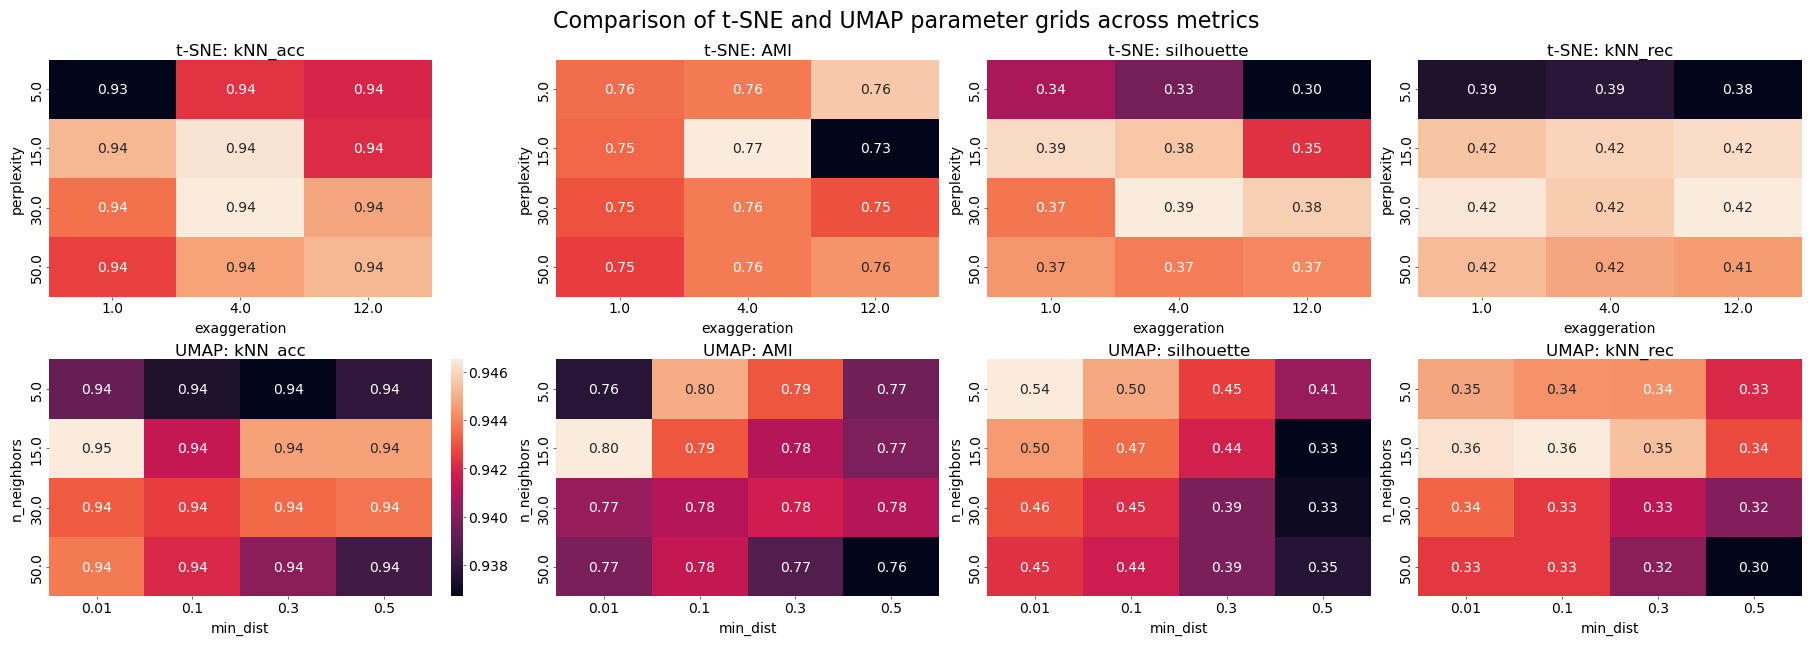

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Showing UMAP colored by RNA family


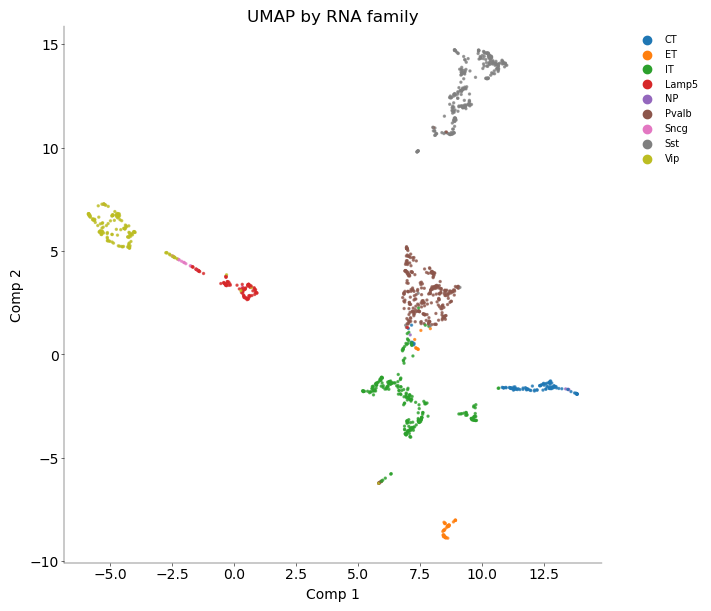

Showing t-SNE colored by RNA family


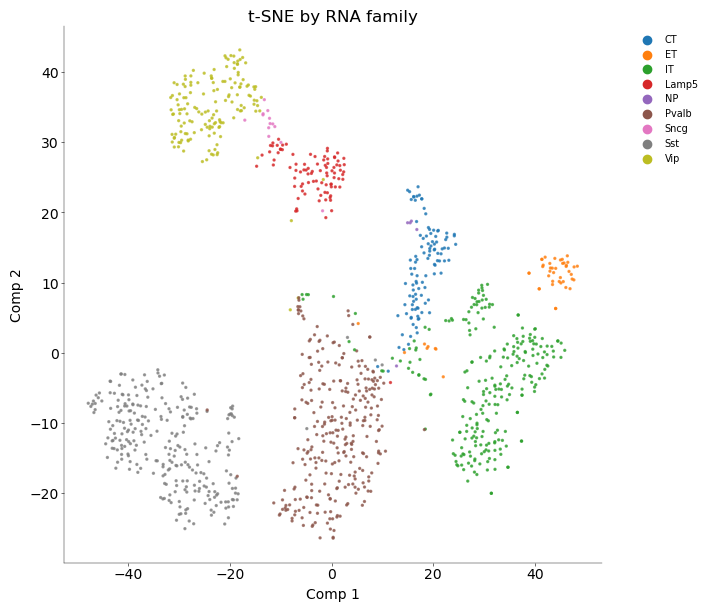

Showing UMAP colored by Layer


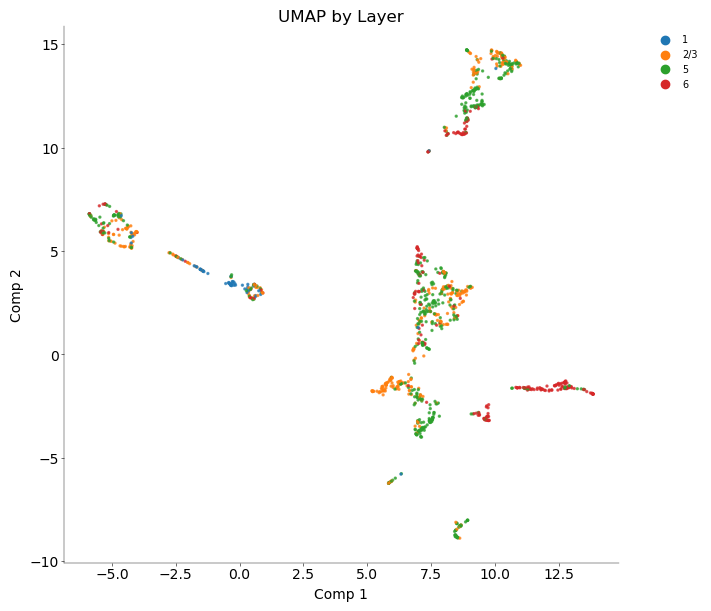

Showing t-SNE colored by Layer


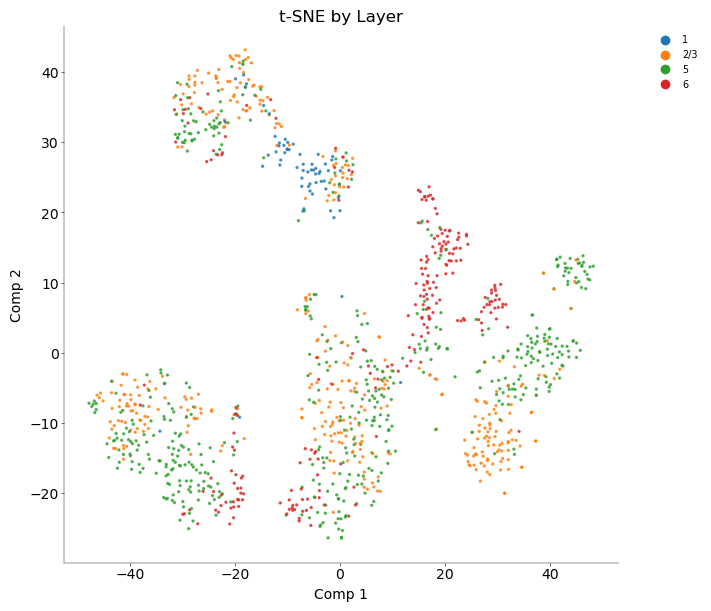

Showing UMAP colored by Cre


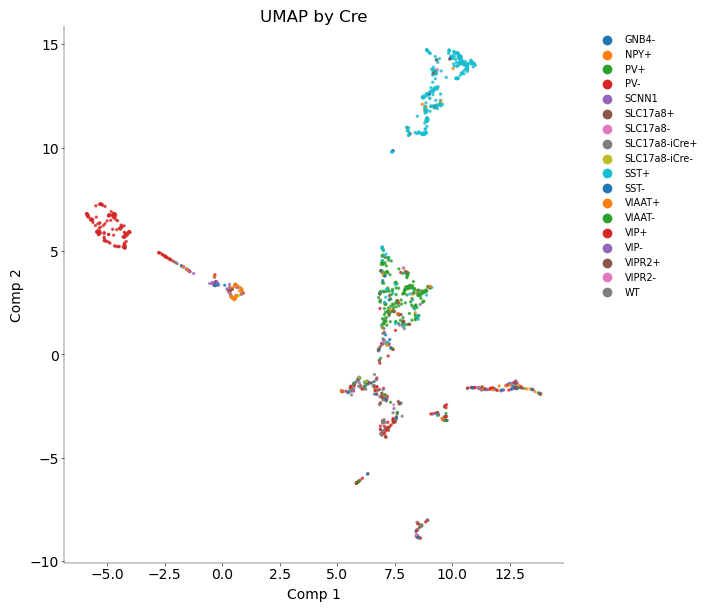

Showing t-SNE colored by Cre


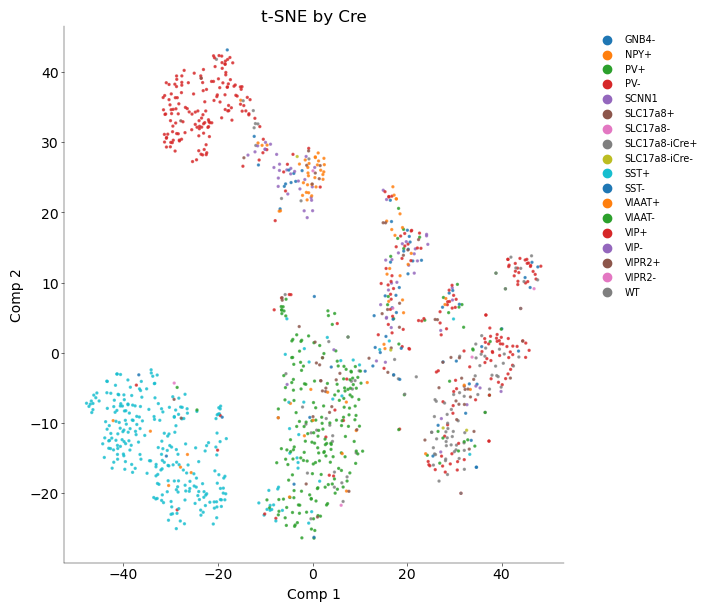

Showing UMAP colored by Batch


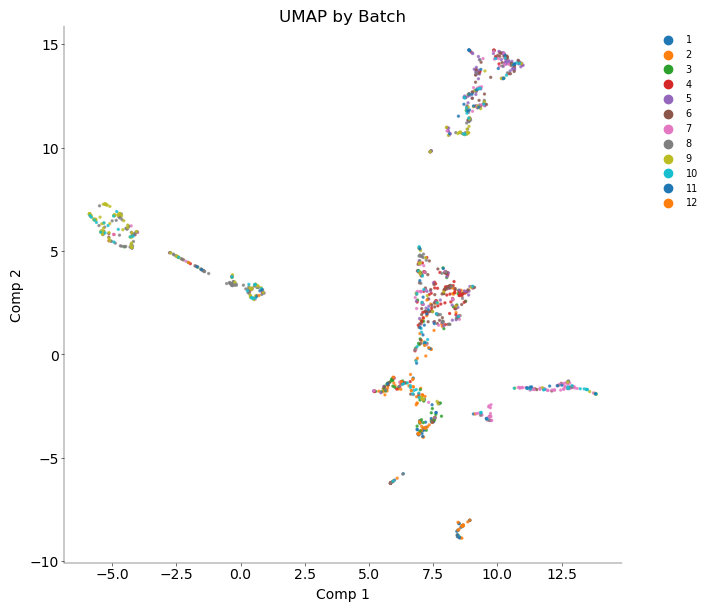

Showing t-SNE colored by Batch


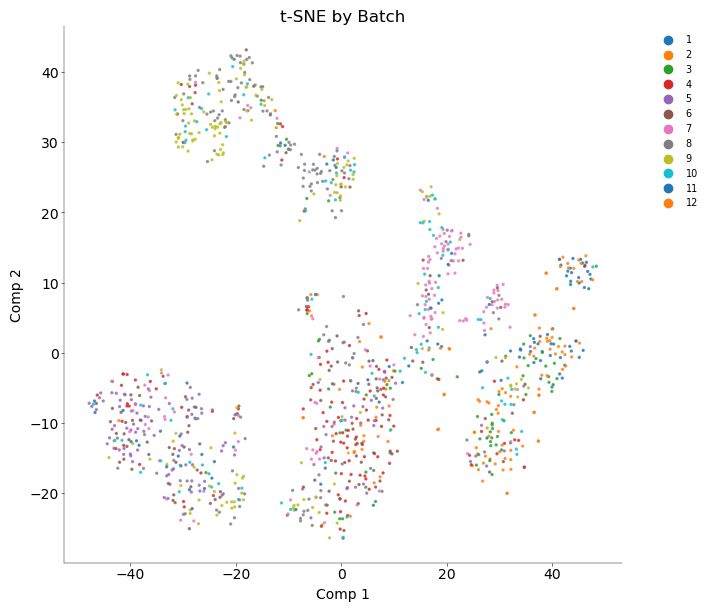

Plotting UMAP colored by AP amplitude (mV) (cells with RNA+ephys)


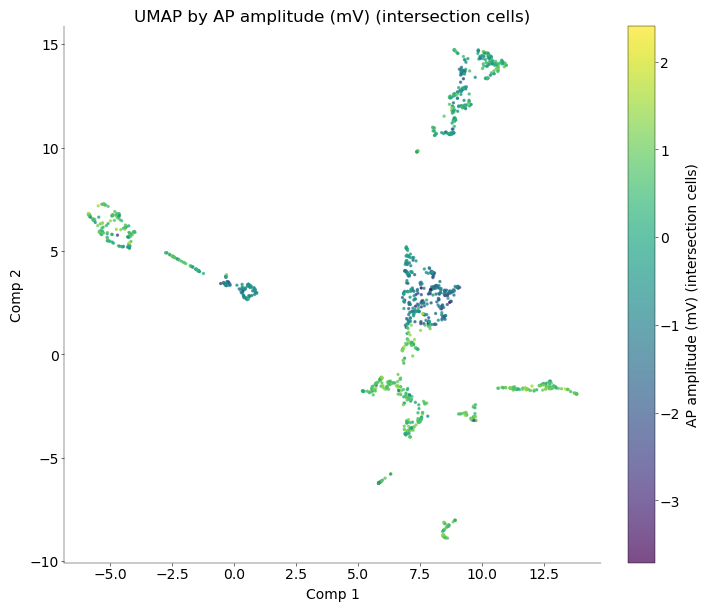

Plotting t-SNE colored by AP amplitude (mV) (cells with RNA+ephys)


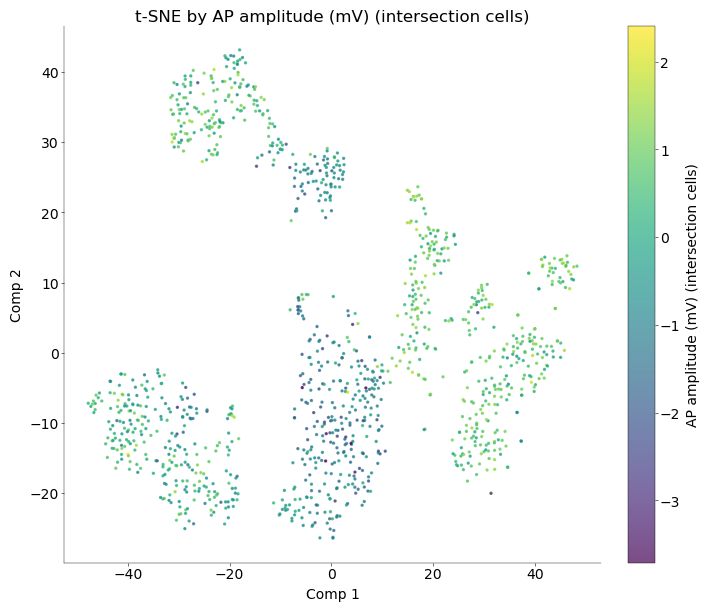

Plotting UMAP colored by AP width (ms) (cells with RNA+ephys)


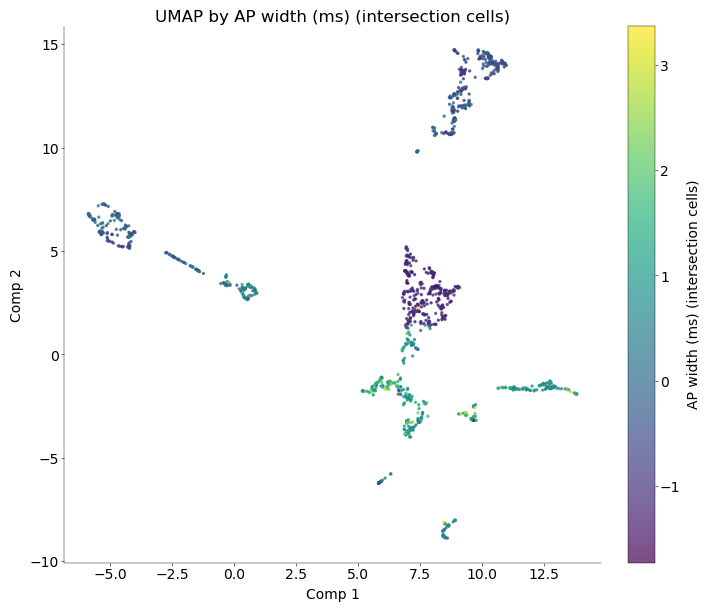

Plotting t-SNE colored by AP width (ms) (cells with RNA+ephys)


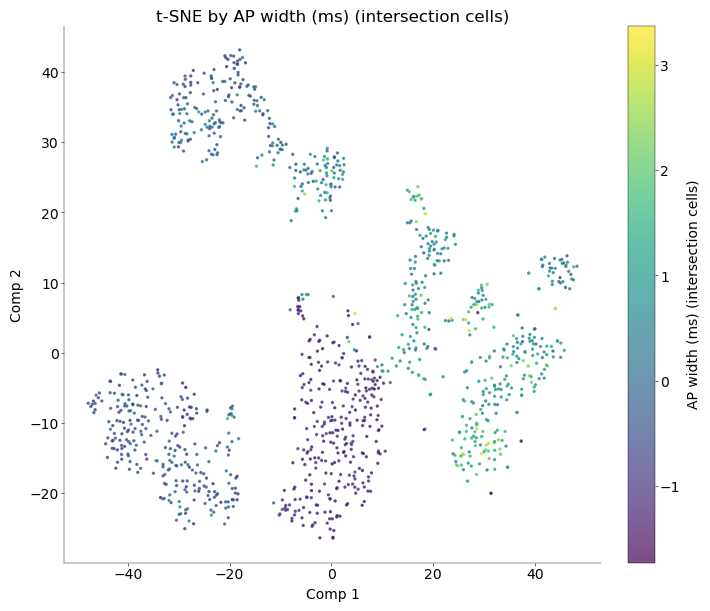

Plotting UMAP colored by Input resistance (MOhm) (cells with RNA+ephys)


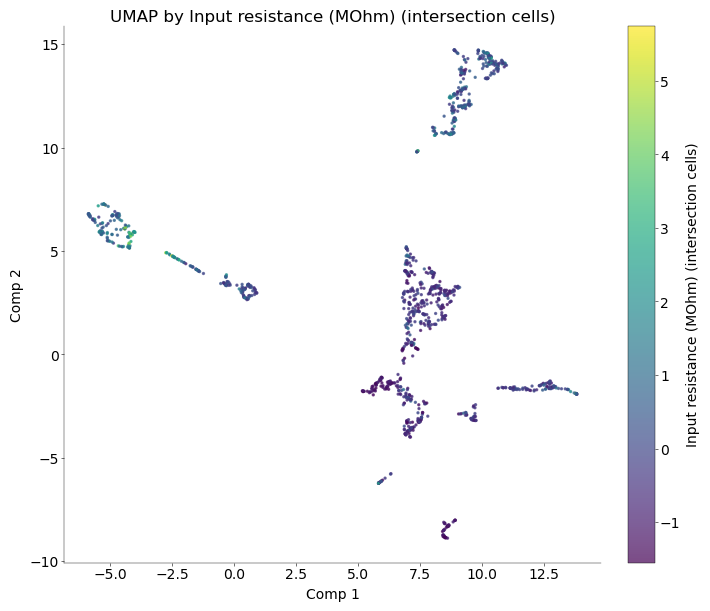

Plotting t-SNE colored by Input resistance (MOhm) (cells with RNA+ephys)


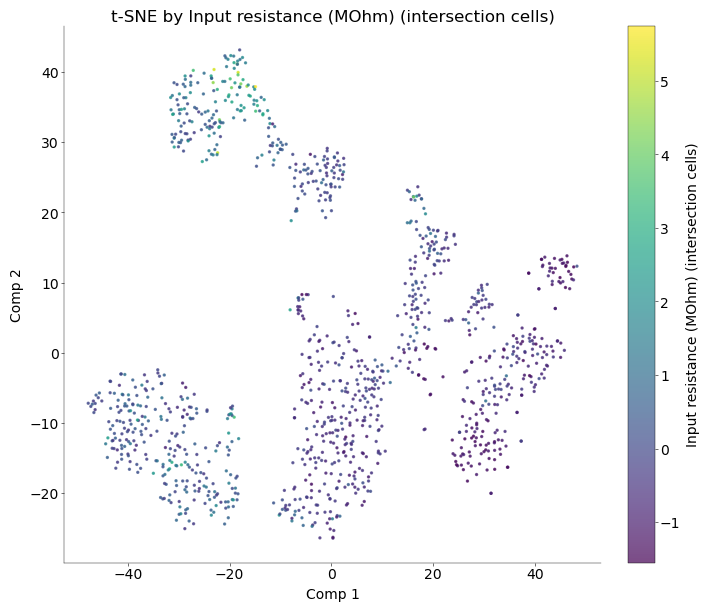

Plotting UMAP colored by Rheobase (pA) (cells with RNA+ephys)


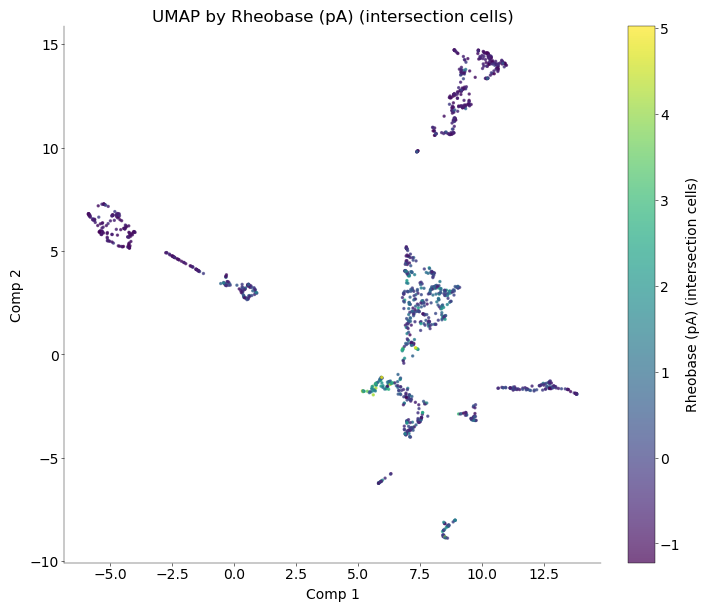

Plotting t-SNE colored by Rheobase (pA) (cells with RNA+ephys)


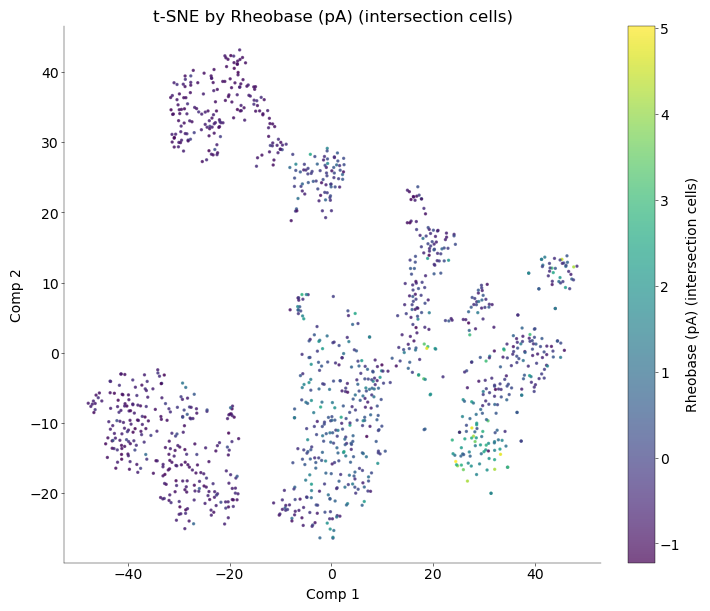

In [ ]:
# -- Color palette utility --
def get_colors(values, palette="tab10"):
    unique_vals = np.unique(values)
    if np.issubdtype(values.dtype, np.number) and len(unique_vals) > 12:
        # continuous, color by value
        return values, None, unique_vals
    else:
        color_map = {
            val: plt.get_cmap(palette)(i % 10)
            for i, val in enumerate(unique_vals)
        }
        colors = [color_map[val] for val in values]
        return colors, color_map, unique_vals


# -- kNN metrics --
def knn_accuracy(embedding, labels, k=10):
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    indices = nbrs.kneighbors(return_distance=False)[:, 1:]
    acc = np.mean(
        [np.mean(labels[indices[i]] == labels[i]) for i in range(len(labels))]
    )
    return acc


def knn_recall(highdim, embedding, k=10):
    nbrs_high = NearestNeighbors(n_neighbors=k + 1).fit(highdim)
    high_idx = nbrs_high.kneighbors(return_distance=False)[:, 1:]
    nbrs_emb = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    emb_idx = nbrs_emb.kneighbors(return_distance=False)[:, 1:]
    recall = np.mean(
        [
            len(set(high_idx[i]) & set(emb_idx[i])) / k
            for i in range(len(highdim))
        ]
    )
    return recall


# -- 2D embedding plotting utility --
def plot_embedding(
    embedding,
    values,
    color_map,
    unique_vals,
    title,
    continuous=False,
    xlabel="Comp 1",
    ylabel="Comp 2",
):
    plt.figure(figsize=(7, 6))
    if continuous:
        sc = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=values,
            s=8,
            alpha=0.7,
            cmap="viridis",
        )
        plt.colorbar(sc, label=title.split("by")[-1].strip())
    else:
        cell_colors = [color_map[val] for val in values]
        plt.scatter(
            embedding[:, 0], embedding[:, 1], c=cell_colors, s=8, alpha=0.7
        )
        for val in unique_vals:
            plt.scatter([], [], color=color_map[val], label=val)
        plt.legend(
            markerscale=2,
            fontsize=7,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# -- Metric reporting helper --
def compute_metrics(embedding, labels, X_highdim, n_clusters, k=10):
    metrics = {}
    metrics["kNN_acc"] = knn_accuracy(embedding, labels, k)
    metrics["kNN_rec"] = knn_recall(X_highdim, embedding, k)
    metrics["silhouette"] = silhouette_score(embedding, labels)
    pred = KMeans(
        n_clusters=n_clusters, n_init=10, random_state=0
    ).fit_predict(embedding)
    metrics["AMI"] = adjusted_mutual_info_score(labels, pred)
    return metrics


# ============= PARAMETERIZED DIM REDUCTION & METRIC GRID =============
# Parameters to sweep
tsne_perplexities = [5, 15, 30, 50]
tsne_exaggerations = [1, 4, 12]
umap_neighbors = [5, 15, 30, 50]
umap_min_dists = [0.01, 0.1, 0.3, 0.5]
k = 10

# -- Choose color labelings to explore
labelings = {
    "RNA family": np.array(rna_family),
    "Layer": np.array(meta_filtered["Targeted layer"]),
    "Cre": np.array(meta_filtered["Cre"]),
    "Batch": np.array(meta_filtered["Sequencing batch"]),
    # Example for continuous feature (e.g. AP amplitude, replace col name if needed)
    "AP amplitude (mV)": (
        np.array(meta_filtered["AP amplitude (mV)"])
        if "AP amplitude (mV)" in meta_filtered.columns
        else None
    ),
}

labelings_rna = {
    "RNA family": np.array(rna_family),  # This should match your log_cpm rows
    "Layer": np.array(
        meta_rna["Targeted layer"]
    ),  # meta_rna: filtered only by RNA QC
    "Cre": np.array(meta_rna["Cre"]),
    "Batch": np.array(meta_rna["Sequencing batch"]),
}

labelings_ephys = {
    "RNA family": np.array(meta_filtered["RNA family"]),
    "Layer": np.array(meta_filtered["Targeted layer"]),
    "Cre": np.array(meta_filtered["Cre"]),
    "Batch": np.array(meta_filtered["Sequencing batch"]),
    "AP amplitude (mV)": np.array(meta_filtered["AP amplitude (mV)"]),
    # ... other ephys features
}
# Remove None (feature missing in meta)
labelings = {k: v for k, v in labelings.items() if v is not None}

# -- Run PCA for PCA/UMAP/t-SNE on PCs (standard)
n_pcs = 50
pca = PCA(n_components=n_pcs)
X_pca_full = pca.fit_transform(logcpm_hvg)
X_pca_2d = X_pca_full[:, :2]

# -- Run UMAP/t-SNE on raw log1p(CPM) HVGs as well
X_umap = umap.UMAP(
    n_neighbors=15, min_dist=0.3, n_components=2, random_state=0
).fit_transform(X_pca_full)
X_tsne = TSNE(
    n_components=2, perplexity=30, max_iter=1000, random_state=0
).fit_transform(X_pca_full)
X_umap_raw = umap.UMAP(
    n_neighbors=15, min_dist=0.3, n_components=2, random_state=0
).fit_transform(logcpm_hvg)
X_tsne_raw = TSNE(
    n_components=2, perplexity=30, max_iter=1000, random_state=0
).fit_transform(logcpm_hvg)

# -- Choose one labeling for quantitative metrics (RNA family), but you can repeat for any label
labels = np.array(rna_family)
n_clusters = len(np.unique(labels))

# -- Compute metrics for PCA, UMAP, t-SNE on both PCA and raw input
embeddings_to_compare = {
    "PCA2": X_pca_2d,
    "UMAP_PCA": X_umap,
    "t-SNE_PCA": X_tsne,
    "UMAP_raw": X_umap_raw,
    "t-SNE_raw": X_tsne_raw,
}
metrics_summary = {}
for method, emb in embeddings_to_compare.items():
    metrics_summary[method] = compute_metrics(
        emb, labels, X_pca_full, n_clusters, k=k
    )

# -- Print metrics table (summary)
print(pd.DataFrame(metrics_summary).T)

# ============= PARAMETER GRID SEARCH (t-SNE, UMAP) =============
results = []

# t-SNE grid
for perp in tsne_perplexities:
    for exag in tsne_exaggerations:
        X_tsne = TSNE(
            n_components=2,
            perplexity=perp,
            early_exaggeration=exag,
            max_iter=1000,
            random_state=0,
        ).fit_transform(X_pca_full)
        res = compute_metrics(X_tsne, labels, X_pca_full, n_clusters, k=k)
        res.update(
            {"method": "t-SNE", "perplexity": perp, "exaggeration": exag}
        )
        results.append(res)

# UMAP grid
for n_neigh in umap_neighbors:
    for min_dist in umap_min_dists:
        X_umap = umap.UMAP(
            n_neighbors=n_neigh,
            min_dist=min_dist,
            n_components=2,
            random_state=0,
        ).fit_transform(X_pca_full)
        res = compute_metrics(X_umap, labels, X_pca_full, n_clusters, k=k)
        res.update(
            {"method": "UMAP", "n_neighbors": n_neigh, "min_dist": min_dist}
        )
        results.append(res)

df_results = pd.DataFrame(results)

# -- Find and print best parameter settings for each metric/method
for metric in ["kNN_acc", "AMI", "silhouette", "kNN_rec"]:
    for method in ["t-SNE", "UMAP"]:
        df = df_results[df_results["method"] == method]
        best_idx = df[metric].idxmax()
        print(f"Best {method} {metric}:")
        print(df.loc[best_idx])


# --- Extract best parameter rows for a chosen metric
def get_best_params_row(df_results, method, metric="silhouette"):
    df = df_results[df_results["method"] == method]
    best_idx = df[metric].idxmax()
    return df.loc[best_idx]


best_metric = "silhouette"  # You can change to "kNN_rec", "AMI", etc.
# For “best” visual cluster separation by cell family:
# → Use silhouette score.
# For preserving single-cell relationships:
# → Use kNN recall.
best_tsne_row = get_best_params_row(df_results, "t-SNE", metric=best_metric)
best_umap_row = get_best_params_row(df_results, "UMAP", metric=best_metric)

# -- Build and print summary table
summary_rows = [
    {
        "Method": "t-SNE",
        "Metric": best_metric,
        "Score": best_tsne_row[best_metric],
        "perplexity": best_tsne_row["perplexity"],
        "early_exaggeration": best_tsne_row["exaggeration"],
        "kNN_acc": best_tsne_row["kNN_acc"],
        "kNN_rec": best_tsne_row["kNN_rec"],
        "AMI": best_tsne_row["AMI"],
    },
    {
        "Method": "UMAP",
        "Metric": best_metric,
        "Score": best_umap_row[best_metric],
        "n_neighbors": best_umap_row["n_neighbors"],
        "min_dist": best_umap_row["min_dist"],
        "kNN_acc": best_umap_row["kNN_acc"],
        "kNN_rec": best_umap_row["kNN_rec"],
        "AMI": best_umap_row["AMI"],
    },
]
summary_df = pd.DataFrame(summary_rows)
print("\nBest embedding parameters and scores summary:")
print(summary_df)


# -- Visualize metric heatmaps (as before)
metrics = ["kNN_acc", "AMI", "silhouette", "kNN_rec"]
method_names = ["t-SNE", "UMAP"]
fig, axes = plt.subplots(len(method_names), len(metrics), figsize=(18, 6))
for col, metric in enumerate(metrics):
    # t-SNE (row 0)
    df_tsne = df_results[df_results["method"] == "t-SNE"]
    pivot_tsne = df_tsne.pivot(
        index="perplexity", columns="exaggeration", values=metric
    )
    sns.heatmap(pivot_tsne, annot=True, fmt=".2f", ax=axes[0, col], cbar=False)
    axes[0, col].set_title(f"t-SNE: {metric}")
    axes[0, col].set_xlabel("exaggeration")
    axes[0, col].set_ylabel("perplexity")
    # UMAP (row 1)
    df_umap = df_results[df_results["method"] == "UMAP"]
    pivot_umap = df_umap.pivot(
        index="n_neighbors", columns="min_dist", values=metric
    )
    sns.heatmap(
        pivot_umap, annot=True, fmt=".2f", ax=axes[1, col], cbar=col == 0
    )
    axes[1, col].set_title(f"UMAP: {metric}")
    axes[1, col].set_xlabel("min_dist")
    axes[1, col].set_ylabel("n_neighbors")
plt.suptitle(
    "Comparison of t-SNE and UMAP parameter grids across metrics",
    y=1.05,
    fontsize=16,
)
plt.show()

# ============= EMBEDDING PLOTS WITH ADDITIONAL LABELINGS/FEATURES =============

# -- Run best UMAP/t-SNE (use best parameters from earlier, or default)
best_umap = umap.UMAP(
    n_neighbors=int(best_umap_row["n_neighbors"]),
    min_dist=float(best_umap_row["min_dist"]),
    n_components=2,
    random_state=0,
).fit_transform(X_pca_full)
best_tsne = TSNE(
    n_components=2,
    perplexity=float(best_tsne_row["perplexity"]),
    early_exaggeration=float(best_tsne_row["exaggeration"]),
    max_iter=1000,
    random_state=0,
).fit_transform(X_pca_full)

for label_name, label_vals in labelings_rna.items():
    assert best_umap.shape[0] == len(
        label_vals
    ), f"Mismatch for {label_name}: {best_umap.shape[0]} vs {len(label_vals)}"
    # For continuous: colorbar, else legend
    continuous = (
        np.issubdtype(label_vals.dtype, np.number)
        and len(np.unique(label_vals)) > 12
    )
    colors, color_map, unique_vals = get_colors(label_vals)
    print(f"Showing UMAP colored by {label_name}")
    plot_embedding(
        best_umap,
        label_vals,
        color_map,
        unique_vals,
        f"UMAP by {label_name}",
        continuous=continuous,
    )
    print(f"Showing t-SNE colored by {label_name}")
    plot_embedding(
        best_tsne,
        label_vals,
        color_map,
        unique_vals,
        f"t-SNE by {label_name}",
        continuous=continuous,
    )

# 1. Find intersection of cells present in both RNA embedding and ephys metadata
cells_rna = np.array(meta_rna["Cell"])
cells_ephys = np.array(meta_filtered["Cell"])

# This mask selects only cells in RNA embedding that also have ephys features
in_both_mask = np.isin(cells_rna, cells_ephys)

# Subset embedding to intersection cells
embedding_umap_inter = best_umap[in_both_mask, :]
embedding_tsne_inter = best_tsne[in_both_mask, :]

# For every intersected RNA cell, find its row in meta_filtered
meta_rna_inter = meta_rna.loc[in_both_mask].reset_index(drop=True)
meta_filtered_idx = [
    np.where(cells_ephys == cid)[0][0] for cid in meta_rna_inter["Cell"]
]

# List of ephys features you want to color by
ephys_features_to_plot = [
    "AP amplitude (mV)",
    "AP width (ms)",
    "Input resistance (MOhm)",
    "Rheobase (pA)",
    # Add more from ephysNames_filtered as desired
]

for feature in ephys_features_to_plot:
    if feature in meta_filtered.columns:
        # Get ephys values, aligned to RNA embedding (intersection only)
        vals = meta_filtered[feature].values[meta_filtered_idx]
        # Plot UMAP
        print(f"Plotting UMAP colored by {feature} (cells with RNA+ephys)")
        plot_embedding(
            embedding_umap_inter,
            vals,
            None,
            None,
            f"UMAP by {feature} (intersection cells)",
            continuous=True,
        )
        # Plot t-SNE
        print(f"Plotting t-SNE colored by {feature} (cells with RNA+ephys)")
        plot_embedding(
            embedding_tsne_inter,
            vals,
            None,
            None,
            f"t-SNE by {feature} (intersection cells)",
            continuous=True,
        )
    else:
        print(f"Feature {feature} not found in meta_filtered.columns")

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


            kNN_acc   kNN_rec  silhouette       AMI
PCA2       0.711851  0.108279    0.085802  0.603839
UMAP_PCA   0.943750  0.347646    0.391782  0.761806
t-SNE_PCA  0.945049  0.421753    0.388397  0.766361
UMAP_raw   0.811688  0.144399    0.114308  0.595579
t-SNE_raw  0.882792  0.233604    0.094033  0.601514


/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarn

Best t-SNE kNN_acc:
kNN_acc         0.946591
kNN_rec         0.421591
silhouette      0.372324
AMI             0.761392
method             t-SNE
perplexity          15.0
exaggeration         1.0
n_neighbors          NaN
min_dist             NaN
Name: 3, dtype: object
Best UMAP kNN_acc:
kNN_acc         0.948458
kNN_rec         0.351461
silhouette      0.508845
AMI              0.83003
method              UMAP
perplexity           NaN
exaggeration         NaN
n_neighbors         15.0
min_dist            0.01
Name: 16, dtype: object
Best t-SNE AMI:
kNN_acc         0.934091
kNN_rec         0.380601
silhouette      0.319191
AMI             0.772674
method             t-SNE
perplexity           5.0
exaggeration         1.0
n_neighbors          NaN
min_dist             NaN
Name: 0, dtype: object
Best UMAP AMI:
kNN_acc         0.948458
kNN_rec         0.351461
silhouette      0.508845
AMI              0.83003
method              UMAP
perplexity           NaN
exaggeration         NaN
n_neighbor

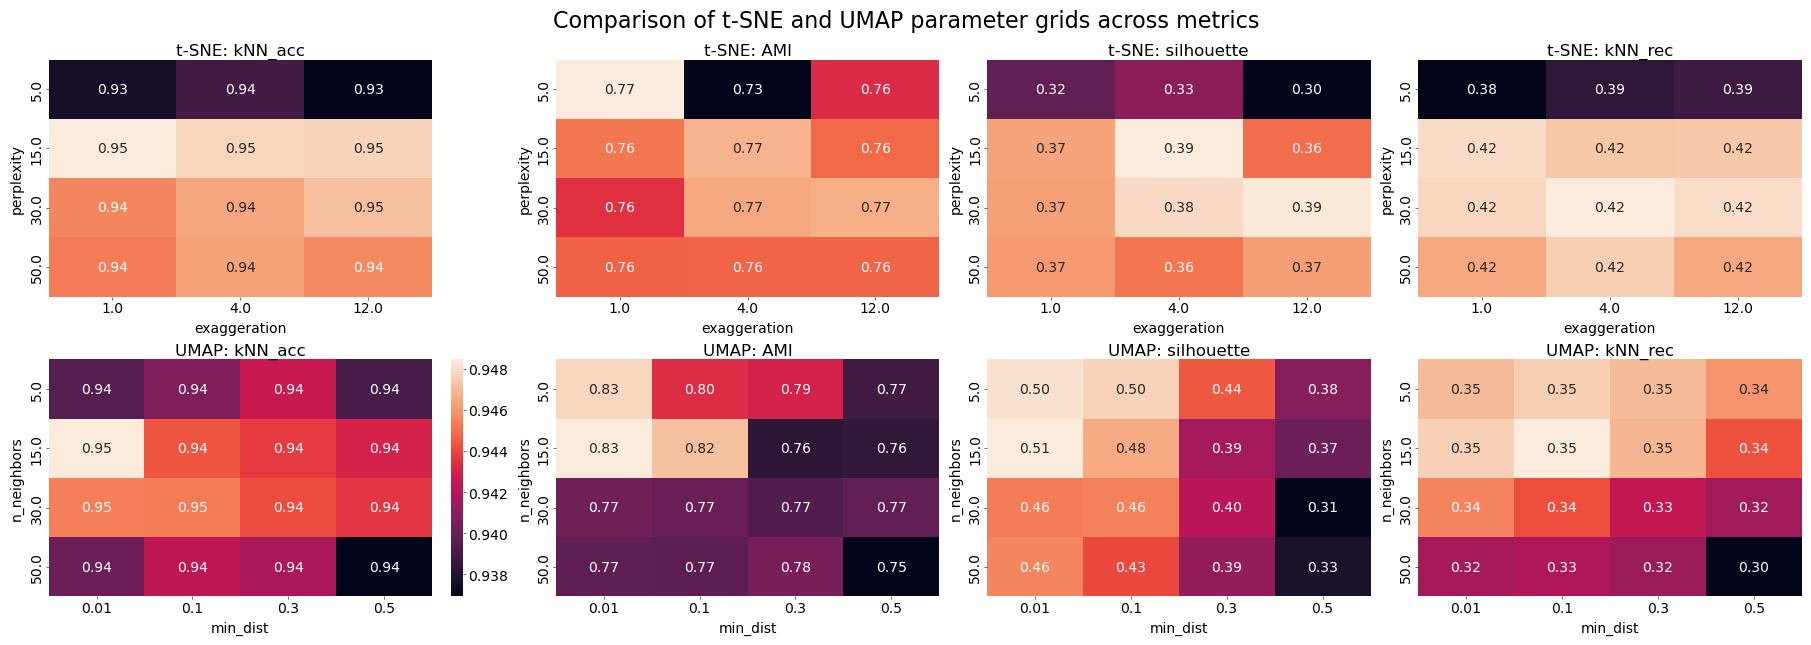

/opt/anaconda3/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Showing UMAP colored by RNA family


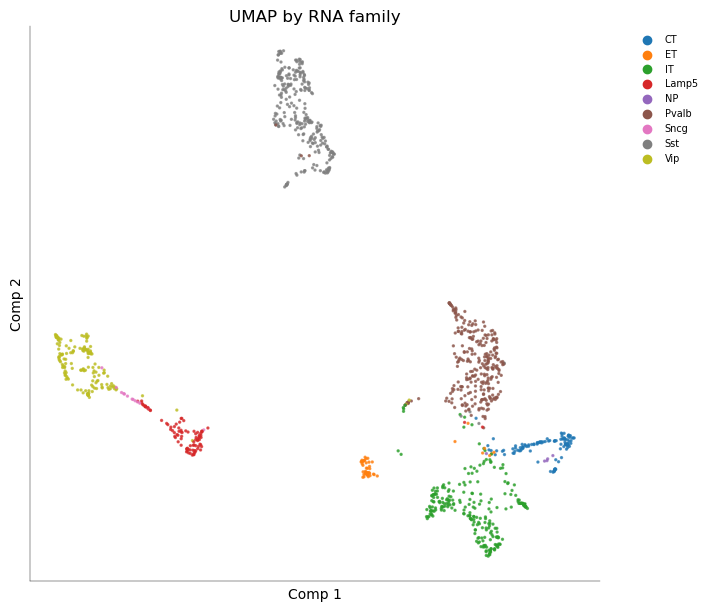

Showing t-SNE colored by RNA family


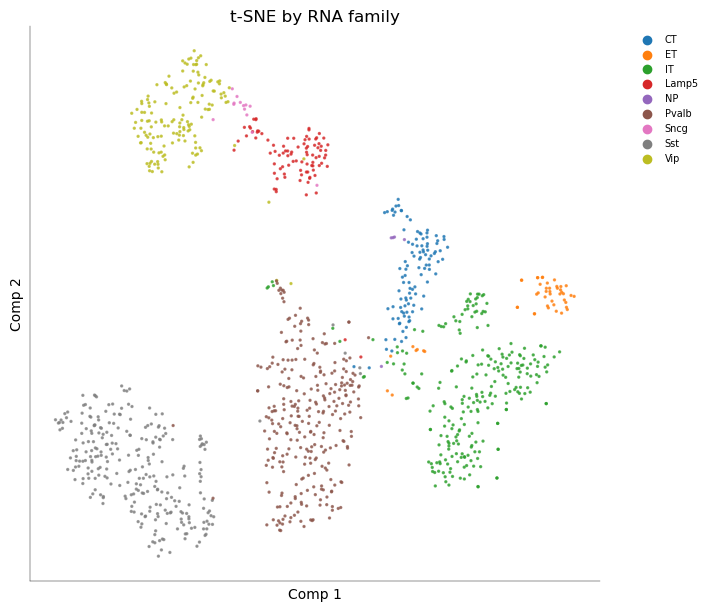

Showing UMAP colored by Layer


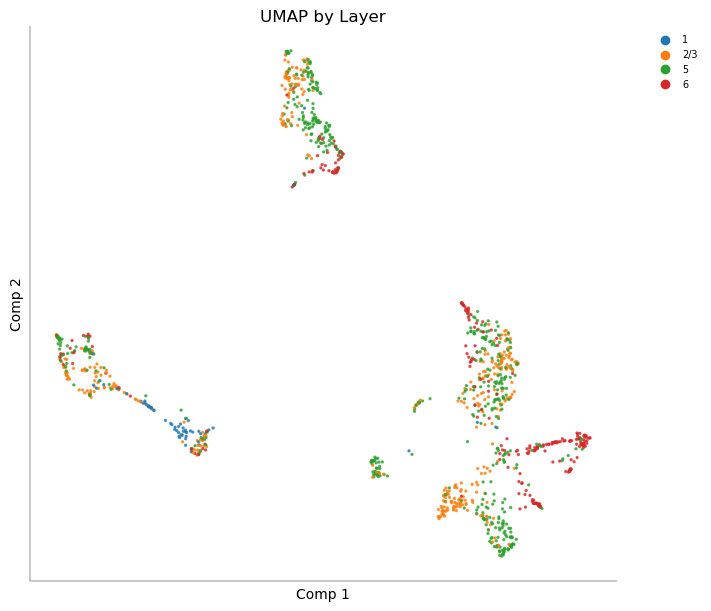

Showing t-SNE colored by Layer


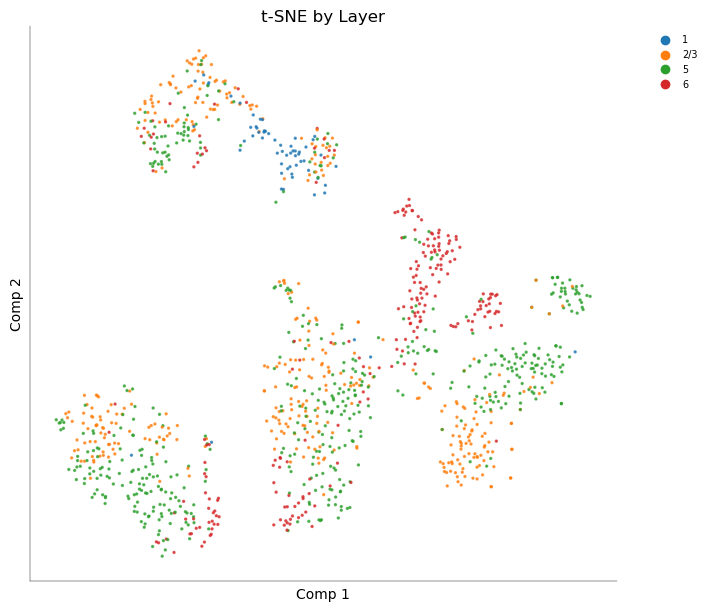

Showing UMAP colored by Cre


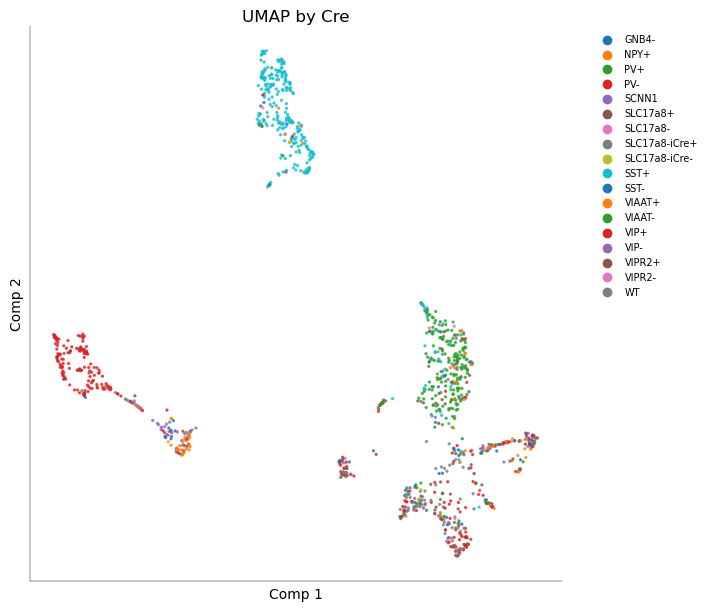

Showing t-SNE colored by Cre


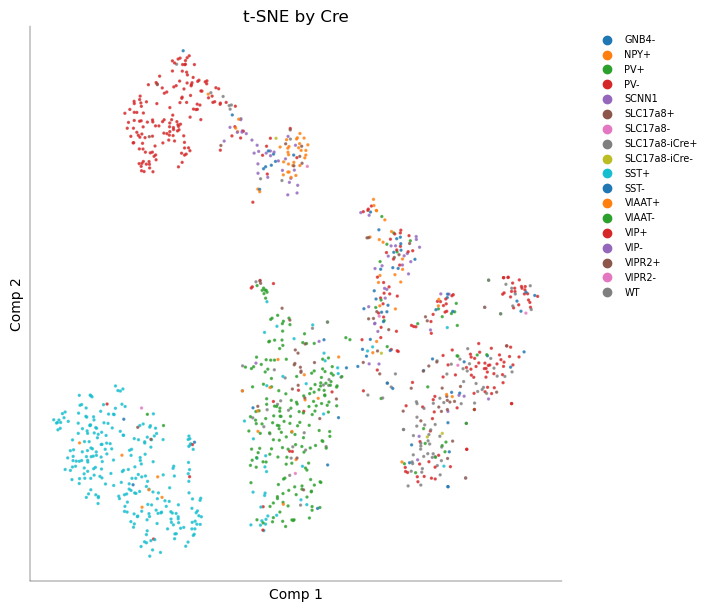

Showing UMAP colored by Batch


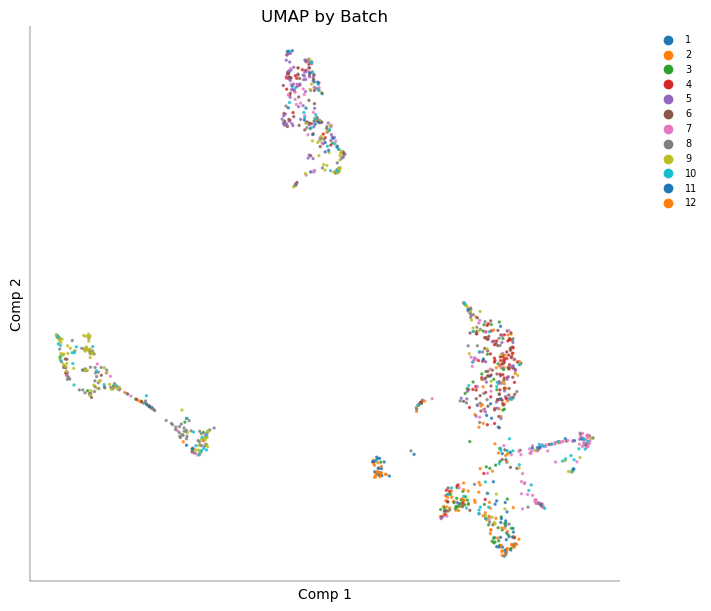

Showing t-SNE colored by Batch


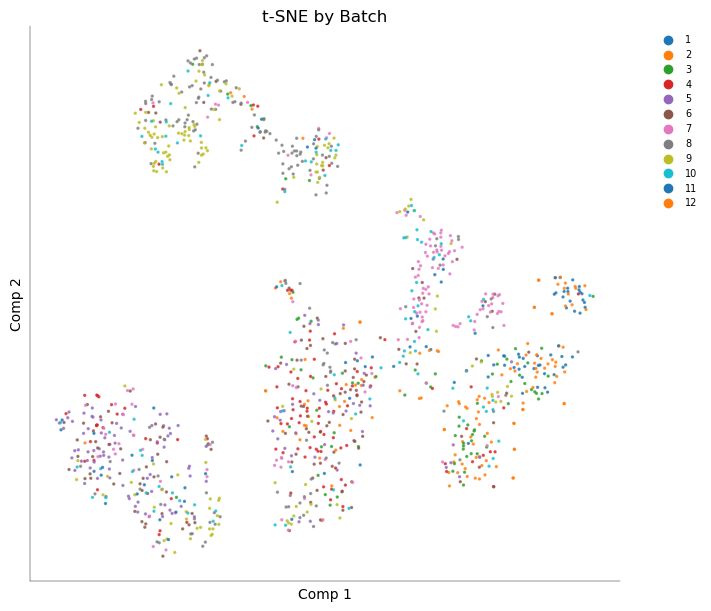

Plotting UMAP colored by AP amplitude (mV) (cells with RNA+ephys)


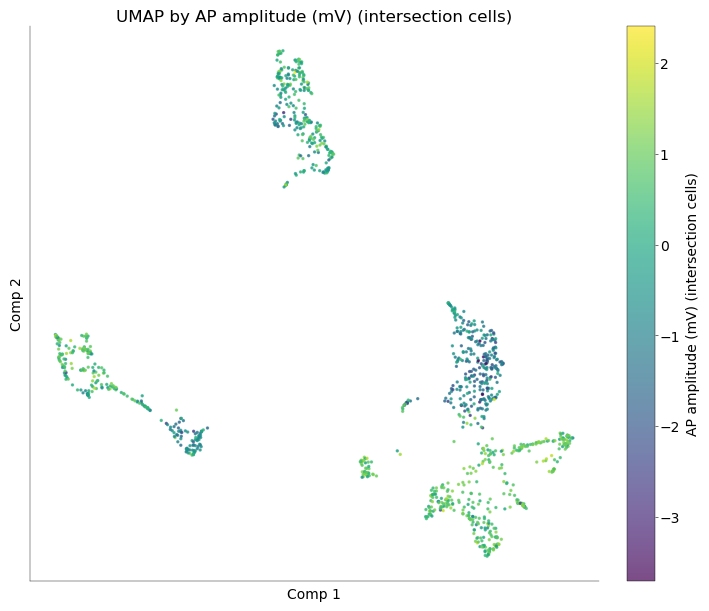

Plotting t-SNE colored by AP amplitude (mV) (cells with RNA+ephys)


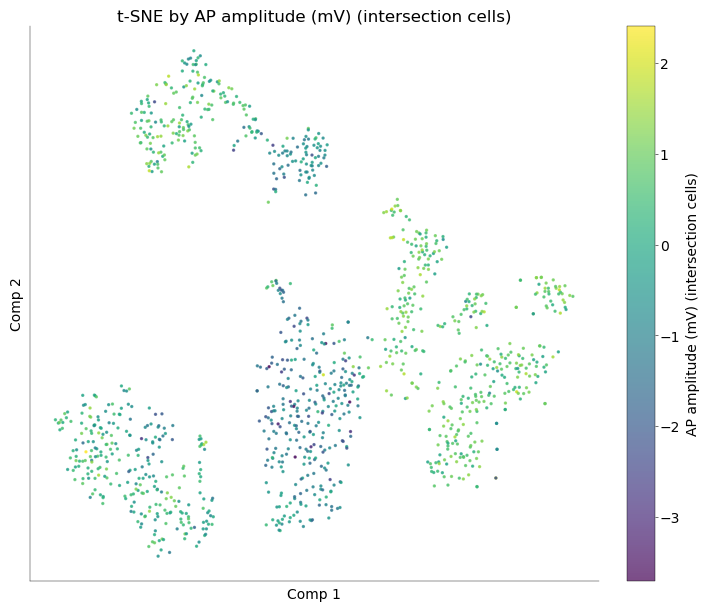

Plotting UMAP colored by AP width (ms) (cells with RNA+ephys)


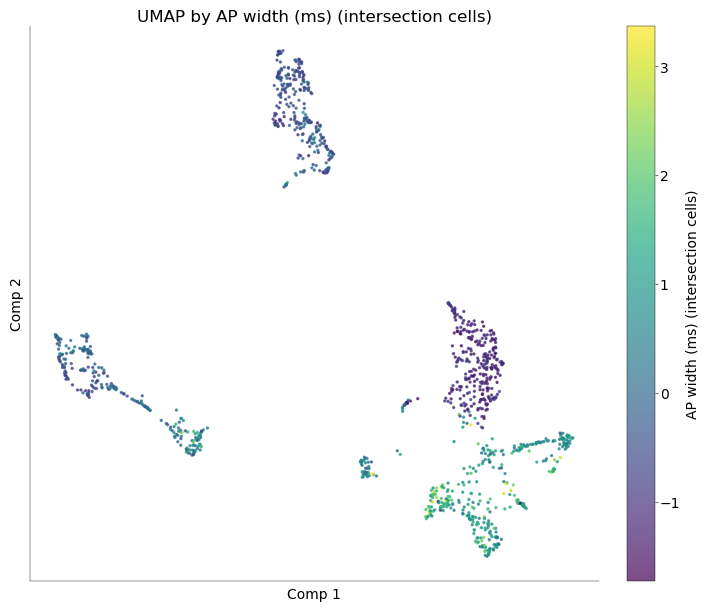

Plotting t-SNE colored by AP width (ms) (cells with RNA+ephys)


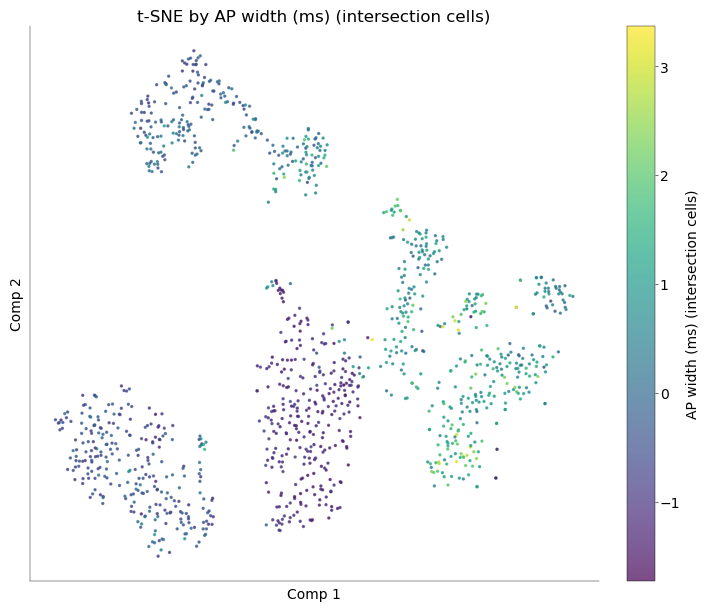

Plotting UMAP colored by Input resistance (MOhm) (cells with RNA+ephys)


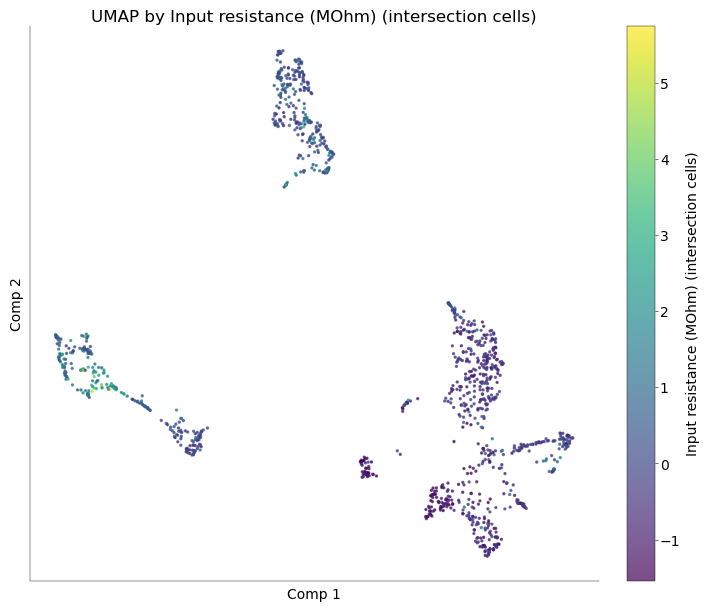

Plotting t-SNE colored by Input resistance (MOhm) (cells with RNA+ephys)


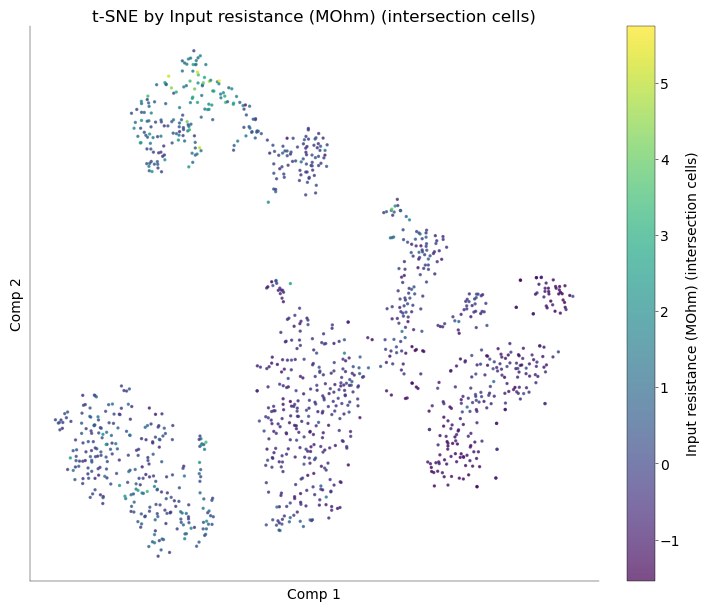

Plotting UMAP colored by Rheobase (pA) (cells with RNA+ephys)


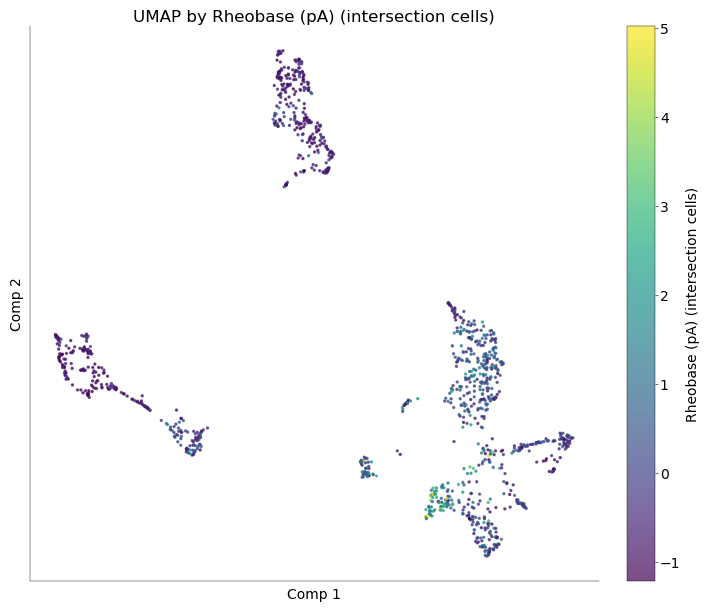

Plotting t-SNE colored by Rheobase (pA) (cells with RNA+ephys)


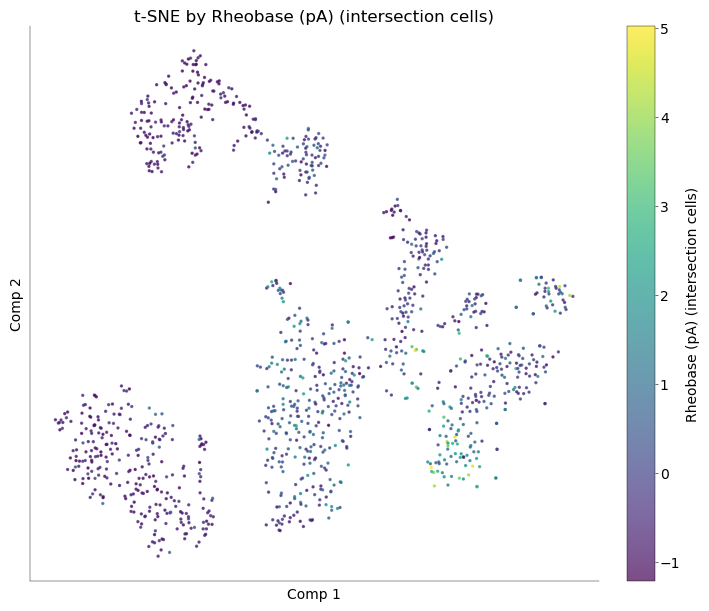

In [63]:
# -- Color palette utility --
def get_colors(values, palette="tab10"):
    unique_vals = np.unique(values)
    if np.issubdtype(values.dtype, np.number) and len(unique_vals) > 12:
        # continuous, color by value
        return values, None, unique_vals
    else:
        color_map = {
            val: plt.get_cmap(palette)(i % 10)
            for i, val in enumerate(unique_vals)
        }
        colors = [color_map[val] for val in values]
        return colors, color_map, unique_vals


# -- kNN metrics --
def knn_accuracy(embedding, labels, k=10):
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    indices = nbrs.kneighbors(return_distance=False)[:, 1:]
    acc = np.mean(
        [np.mean(labels[indices[i]] == labels[i]) for i in range(len(labels))]
    )
    return acc


def knn_recall(highdim, embedding, k=10):
    nbrs_high = NearestNeighbors(n_neighbors=k + 1).fit(highdim)
    high_idx = nbrs_high.kneighbors(return_distance=False)[:, 1:]
    nbrs_emb = NearestNeighbors(n_neighbors=k + 1).fit(embedding)
    emb_idx = nbrs_emb.kneighbors(return_distance=False)[:, 1:]
    recall = np.mean(
        [
            len(set(high_idx[i]) & set(emb_idx[i])) / k
            for i in range(len(highdim))
        ]
    )
    return recall


# -- 2D embedding plotting utility --
def plot_embedding(
    embedding,
    values,
    color_map,
    unique_vals,
    title,
    continuous=False,
    xlabel="Comp 1",
    ylabel="Comp 2",
):
    plt.figure(figsize=(7, 6))
    if continuous:
        sc = plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=values,
            s=8,
            alpha=0.7,
            cmap="viridis",
        )
        plt.colorbar(sc, label=title.split("by")[-1].strip())
    else:
        cell_colors = [color_map[val] for val in values]
        plt.scatter(
            embedding[:, 0], embedding[:, 1], c=cell_colors, s=8, alpha=0.7
        )
        for val in unique_vals:
            plt.scatter([], [], color=color_map[val], label=val)
        plt.legend(
            markerscale=2,
            fontsize=7,
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([])
    plt.yticks([])
    plt.show()


# -- Metric reporting helper --
def compute_metrics(embedding, labels, X_highdim, n_clusters, k=10):
    metrics = {}
    metrics["kNN_acc"] = knn_accuracy(embedding, labels, k)
    metrics["kNN_rec"] = knn_recall(X_highdim, embedding, k)
    metrics["silhouette"] = silhouette_score(embedding, labels)
    pred = KMeans(
        n_clusters=n_clusters, n_init=10, random_state=0
    ).fit_predict(embedding)
    metrics["AMI"] = adjusted_mutual_info_score(labels, pred)
    return metrics


# ============= PARAMETERIZED DIM REDUCTION & METRIC GRID =============
# Parameters to sweep
tsne_perplexities = [5, 15, 30, 50]
tsne_exaggerations = [1, 4, 12]
umap_neighbors = [5, 15, 30, 50]
umap_min_dists = [0.01, 0.1, 0.3, 0.5]
k = 10

# -- Choose color labelings to explore
labelings = {
    "RNA family": np.array(rna_family),
    "Layer": np.array(meta_filtered["Targeted layer"]),
    "Cre": np.array(meta_filtered["Cre"]),
    "Batch": np.array(meta_filtered["Sequencing batch"]),
    # Example for continuous feature (e.g. AP amplitude, replace col name if needed)
    "AP amplitude (mV)": (
        np.array(meta_filtered["AP amplitude (mV)"])
        if "AP amplitude (mV)" in meta_filtered.columns
        else None
    ),
}

labelings_rna = {
    "RNA family": np.array(rna_family),  # This should match your log_cpm rows
    "Layer": np.array(
        meta_rna["Targeted layer"]
    ),  # meta_rna: filtered only by RNA QC
    "Cre": np.array(meta_rna["Cre"]),
    "Batch": np.array(meta_rna["Sequencing batch"]),
}

labelings_ephys = {
    "RNA family": np.array(meta_filtered["RNA family"]),
    "Layer": np.array(meta_filtered["Targeted layer"]),
    "Cre": np.array(meta_filtered["Cre"]),
    "Batch": np.array(meta_filtered["Sequencing batch"]),
    "AP amplitude (mV)": np.array(meta_filtered["AP amplitude (mV)"]),
    # ... other ephys features
}
# Remove None (feature missing in meta)
labelings = {k: v for k, v in labelings.items() if v is not None}

# -- Run PCA for PCA/UMAP/t-SNE on PCs (standard)
n_pcs = 50
pca = PCA(n_components=n_pcs)
X_pca_full = pca.fit_transform(logcpm_hvg)
X_pca_2d = X_pca_full[:, :2]

# -- Run UMAP/t-SNE on raw log1p(CPM) HVGs as well
X_umap = umap.UMAP(
    n_neighbors=15, min_dist=0.3, n_components=2, random_state=0
).fit_transform(X_pca_full)
X_tsne = TSNE(
    n_components=2, perplexity=30, max_iter=1000, random_state=0
).fit_transform(X_pca_full)
X_umap_raw = umap.UMAP(
    n_neighbors=15, min_dist=0.3, n_components=2, random_state=0
).fit_transform(logcpm_hvg)
X_tsne_raw = TSNE(
    n_components=2, perplexity=30, max_iter=1000, random_state=0
).fit_transform(logcpm_hvg)

# -- Choose one labeling for quantitative metrics (RNA family), but you can repeat for any label
labels = np.array(rna_family)
n_clusters = len(np.unique(labels))

# -- Compute metrics for PCA, UMAP, t-SNE on both PCA and raw input
embeddings_to_compare = {
    "PCA2": X_pca_2d,
    "UMAP_PCA": X_umap,
    "t-SNE_PCA": X_tsne,
    "UMAP_raw": X_umap_raw,
    "t-SNE_raw": X_tsne_raw,
}
metrics_summary = {}
for method, emb in embeddings_to_compare.items():
    metrics_summary[method] = compute_metrics(
        emb, labels, X_pca_full, n_clusters, k=k
    )

# -- Print metrics table (summary)
print(pd.DataFrame(metrics_summary).T)

# ============= PARAMETER GRID SEARCH (t-SNE, UMAP) =============
results = []

# t-SNE grid
for perp in tsne_perplexities:
    for exag in tsne_exaggerations:
        X_tsne = TSNE(
            n_components=2,
            perplexity=perp,
            early_exaggeration=exag,
            max_iter=1000,
            random_state=0,
        ).fit_transform(X_pca_full)
        res = compute_metrics(X_tsne, labels, X_pca_full, n_clusters, k=k)
        res.update(
            {"method": "t-SNE", "perplexity": perp, "exaggeration": exag}
        )
        results.append(res)

# UMAP grid
for n_neigh in umap_neighbors:
    for min_dist in umap_min_dists:
        X_umap = umap.UMAP(
            n_neighbors=n_neigh,
            min_dist=min_dist,
            n_components=2,
            random_state=0,
        ).fit_transform(X_pca_full)
        res = compute_metrics(X_umap, labels, X_pca_full, n_clusters, k=k)
        res.update(
            {"method": "UMAP", "n_neighbors": n_neigh, "min_dist": min_dist}
        )
        results.append(res)

df_results = pd.DataFrame(results)

# -- Find and print best parameter settings for each metric/method
for metric in ["kNN_acc", "AMI", "silhouette", "kNN_rec"]:
    for method in ["t-SNE", "UMAP"]:
        df = df_results[df_results["method"] == method]
        best_idx = df[metric].idxmax()
        print(f"Best {method} {metric}:")
        print(df.loc[best_idx])

# -- Visualize metric heatmaps (as before)
metrics = ["kNN_acc", "AMI", "silhouette", "kNN_rec"]
method_names = ["t-SNE", "UMAP"]
fig, axes = plt.subplots(len(method_names), len(metrics), figsize=(18, 6))
for col, metric in enumerate(metrics):
    # t-SNE (row 0)
    df_tsne = df_results[df_results["method"] == "t-SNE"]
    pivot_tsne = df_tsne.pivot(
        index="perplexity", columns="exaggeration", values=metric
    )
    sns.heatmap(pivot_tsne, annot=True, fmt=".2f", ax=axes[0, col], cbar=False)
    axes[0, col].set_title(f"t-SNE: {metric}")
    axes[0, col].set_xlabel("exaggeration")
    axes[0, col].set_ylabel("perplexity")
    # UMAP (row 1)
    df_umap = df_results[df_results["method"] == "UMAP"]
    pivot_umap = df_umap.pivot(
        index="n_neighbors", columns="min_dist", values=metric
    )
    sns.heatmap(
        pivot_umap, annot=True, fmt=".2f", ax=axes[1, col], cbar=col == 0
    )
    axes[1, col].set_title(f"UMAP: {metric}")
    axes[1, col].set_xlabel("min_dist")
    axes[1, col].set_ylabel("n_neighbors")
plt.suptitle(
    "Comparison of t-SNE and UMAP parameter grids across metrics",
    y=1.05,
    fontsize=16,
)
plt.show()

# ============= EMBEDDING PLOTS WITH ADDITIONAL LABELINGS/FEATURES =============

# -- Run best UMAP/t-SNE (use best parameters from earlier, or default)
best_umap = umap.UMAP(
    n_neighbors=15, min_dist=0.1, n_components=2, random_state=0
).fit_transform(X_pca_full)
best_tsne = TSNE(
    n_components=2,
    perplexity=30,
    early_exaggeration=4,
    max_iter=1000,
    random_state=0,
).fit_transform(X_pca_full)

for label_name, label_vals in labelings_rna.items():
    assert best_umap.shape[0] == len(
        label_vals
    ), f"Mismatch for {label_name}: {best_umap.shape[0]} vs {len(label_vals)}"
    # For continuous: colorbar, else legend
    continuous = (
        np.issubdtype(label_vals.dtype, np.number)
        and len(np.unique(label_vals)) > 12
    )
    colors, color_map, unique_vals = get_colors(label_vals)
    print(f"Showing UMAP colored by {label_name}")
    plot_embedding(
        best_umap,
        label_vals,
        color_map,
        unique_vals,
        f"UMAP by {label_name}",
        continuous=continuous,
    )
    print(f"Showing t-SNE colored by {label_name}")
    plot_embedding(
        best_tsne,
        label_vals,
        color_map,
        unique_vals,
        f"t-SNE by {label_name}",
        continuous=continuous,
    )

# 1. Find intersection of cells present in both RNA embedding and ephys metadata
cells_rna = np.array(meta_rna["Cell"])
cells_ephys = np.array(meta_filtered["Cell"])

# This mask selects only cells in RNA embedding that also have ephys features
in_both_mask = np.isin(cells_rna, cells_ephys)

# Subset embedding to intersection cells
embedding_umap_inter = best_umap[in_both_mask, :]
embedding_tsne_inter = best_tsne[in_both_mask, :]

# For every intersected RNA cell, find its row in meta_filtered
meta_rna_inter = meta_rna.loc[in_both_mask].reset_index(drop=True)
meta_filtered_idx = [
    np.where(cells_ephys == cid)[0][0] for cid in meta_rna_inter["Cell"]
]

# List of ephys features you want to color by
ephys_features_to_plot = [
    "AP amplitude (mV)",
    "AP width (ms)",
    "Input resistance (MOhm)",
    "Rheobase (pA)",
    # Add more from ephysNames_filtered as desired
]

for feature in ephys_features_to_plot:
    if feature in meta_filtered.columns:
        # Get ephys values, aligned to RNA embedding (intersection only)
        vals = meta_filtered[feature].values[meta_filtered_idx]
        # Plot UMAP
        print(f"Plotting UMAP colored by {feature} (cells with RNA+ephys)")
        plot_embedding(
            embedding_umap_inter,
            vals,
            None,
            None,
            f"UMAP by {feature} (intersection cells)",
            continuous=True,
        )
        # Plot t-SNE
        print(f"Plotting t-SNE colored by {feature} (cells with RNA+ephys)")
        plot_embedding(
            embedding_tsne_inter,
            vals,
            None,
            None,
            f"t-SNE by {feature} (intersection cells)",
            continuous=True,
        )
    else:
        print(f"Feature {feature} not found in meta_filtered.columns")

**4) Clustering.** To find cell types in the RNA count data, you will need to look for clusters. Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2). Feel free to simplify the setup from the paper and not optimize over the set of important genes S but fix it instead, or skip the split and merge part of their clustering algorithm. A vanilla NBMM implementation should suffice. Take into account that the NBMM tries to cluster data that follows a negative binomial distribution. Therefore, it does not make sense to apply this clustering method to all kinds of normalized and transformed data. Please refer to the Harris et al. 2018 publication for the appropriate choice of normalization, and reflect on why this normalization makes sense. Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

In [ ]:
import scanpy as sc
import anndata
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score,
    completeness_score,
    silhouette_score,
)
from scipy.special import gammaln

NBMM, K=4, best AMI=0.466, init=k-means
NBMM, K=5, best AMI=0.416, init=k-means
NBMM, K=6, best AMI=0.531, init=k-means
NBMM, K=7, best AMI=0.529, init=k-means
NBMM, K=8, best AMI=0.511, init=k-means
NBMM, K=9, best AMI=0.478, init=k-means
NBMM, K=10, best AMI=0.472, init=k-means
NBMM, K=11, best AMI=0.460, init=k-means
NBMM, K=12, best AMI=0.427, init=k-means
NBMM, K=13, best AMI=0.461, init=k-means
NBMM, K=14, best AMI=0.416, init=k-means
NBMM, K=15, best AMI=0.403, init=k-means
NBMM, K=16, best AMI=0.399, init=k-means


/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/3612653085.py:163: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


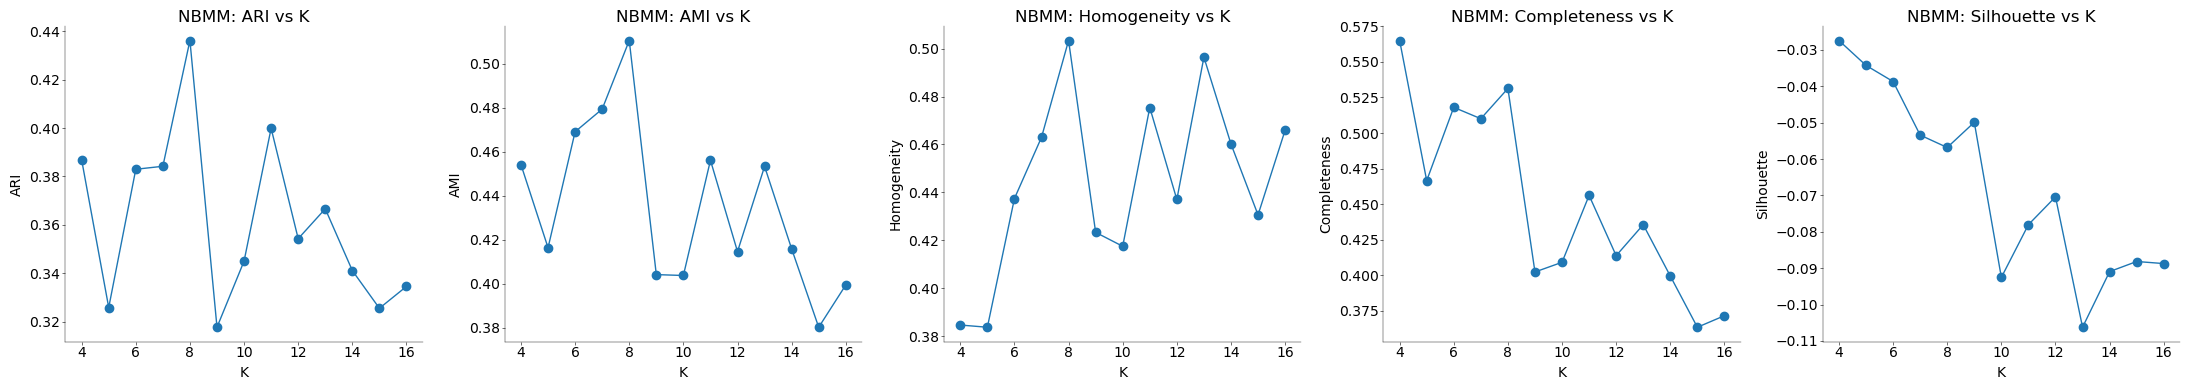

In [ ]:
# --- A. Prepare data as before ---

# Library-size normalize raw counts (Harris et al 2018)
total_counts = exonCounts.sum(axis=1, keepdims=True)
mean_total = total_counts.mean()
X_nbmm = exonCounts / total_counts * mean_total

# Select HVGs
gene_means = X_nbmm.mean(axis=0)
gene_vars = X_nbmm.var(axis=0)
gene_disp = gene_vars / (gene_means + 1e-10)
N_HVG = 500
top_idx = np.argsort(gene_disp)[-N_HVG:]
genes_hvg = genes[top_idx]
X_nbmm_hvg = X_nbmm[:, top_idx]

# For Leiden: log1p(CPM) + PCA
cpm = exonCounts / exonCounts.sum(axis=1, keepdims=True) * 1e6
log_cpm = np.log1p(cpm)
log_cpm_hvg = log_cpm[:, top_idx]

adata = anndata.AnnData(X=log_cpm_hvg)
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca")
sc.tl.leiden(adata, resolution=1.0)
leiden_labels = np.array(adata.obs["leiden"])

# For GMM: PCA on log1p(CPM)
X_pca = PCA(n_components=50).fit_transform(log_cpm_hvg)

# For embedding visualization
# Use best_umap, best_tsne, or compute anew if needed
embedding = best_umap  # UMAP coordinates (n_cells x 2)


# --- NBMM functions ---
def negbinom_logpdf(x, mu, r):
    x = np.asarray(x)
    mu = np.asarray(mu)
    logp = []
    for k in range(mu.shape[0]):
        m = mu[k] + 1e-8
        term1 = gammaln(x + r) - gammaln(r) - gammaln(x + 1)
        term2 = r * np.log(r / (r + m)) + x * np.log(m / (r + m) + 1e-10)
        logp.append((term1 + term2).sum(axis=1))
    return np.array(logp).T  # (cells x clusters)


def fit_nbmm(X, K=8, r=2, n_iter=50, init_mu=None, init_pis=None):
    n_cells, n_genes = X.shape
    # Initialization
    np.random.seed(0)
    if init_mu is not None:
        cluster_means = np.copy(init_mu)
    else:
        cluster_means = np.random.poisson(X.mean(axis=0), (K, n_genes))
    pis = np.ones(K) / K if init_pis is None else np.copy(init_pis)
    logliks = []
    for it in range(n_iter):
        # E-step
        log_probs = negbinom_logpdf(X, cluster_means, r) + np.log(pis + 1e-10)
        log_probs = log_probs - log_probs.max(axis=1, keepdims=True)
        probs = np.exp(log_probs)
        gamma = probs / probs.sum(axis=1, keepdims=True)
        Nk = gamma.sum(axis=0)
        # M-step
        for k in range(K):
            cluster_means[k] = (gamma[:, k][:, None] * X).sum(axis=0) / (
                Nk[k] + 1e-10
            )
        pis = Nk / n_cells
        # Log-likelihood (for convergence plot)
        ll = (np.log((probs.sum(axis=1) + 1e-12))).sum()
        logliks.append(ll)
    assignments = gamma.argmax(axis=1)
    return assignments, cluster_means, logliks


# --- B. Try a range of K (and multiple inits) ---

metrics = [
    ("ARI", adjusted_rand_score),
    ("AMI", adjusted_mutual_info_score),
    ("Homogeneity", homogeneity_score),
    ("Completeness", completeness_score),
    (
        "Silhouette",
        lambda y_true, y_pred: silhouette_score(X_nbmm_hvg, y_pred),
    ),
]

label_sets = {}
metric_results = {m[0]: [] for m in metrics}
nbmm_logliks = []
ks = range(4, 17)  # K from 4 to 16
nbmm_assignments_per_k = []
best_nbmm_metrics = []
best_nbmm_inits = []
n_init_nbmm = 3  # Number of initializations per K

for K in ks:
    best_metric = -np.inf
    best_labels = None
    best_init_type = ""
    best_ll = None
    for i_init in range(n_init_nbmm):
        # --- Init 1: k-means on X_nbmm_hvg
        km = KMeans(n_clusters=K, n_init=3, random_state=i_init)
        labels_km = km.fit_predict(X_nbmm_hvg)
        init_mu_km = np.zeros((K, X_nbmm_hvg.shape[1]))
        for k in range(K):
            init_mu_km[k] = X_nbmm_hvg[labels_km == k].mean(axis=0)
        # Try NBMM with k-means init
        nbmm_labels, _, logliks = fit_nbmm(
            X_nbmm_hvg, K=K, r=2, n_iter=50, init_mu=init_mu_km
        )
        # Evaluate on ground truth
        silhouette = silhouette_score(X_nbmm_hvg, nbmm_labels)
        ARI = adjusted_rand_score(rna_family, nbmm_labels)
        AMI = adjusted_mutual_info_score(rna_family, nbmm_labels)
        Hom = homogeneity_score(rna_family, nbmm_labels)
        Com = completeness_score(rna_family, nbmm_labels)
        # Select best by AMI, but you could use other metric
        curr_metric = AMI
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_labels = nbmm_labels
            best_init_type = "k-means"
            best_ll = logliks
    nbmm_assignments_per_k.append(best_labels)
    best_nbmm_metrics.append([K, ARI, AMI, Hom, Com, silhouette])
    best_nbmm_inits.append(best_init_type)
    nbmm_logliks.append(best_ll)
    # For metrics-vs-K plots
    for (metric_name, _), val in zip(
        metrics, [ARI, AMI, Hom, Com, silhouette]
    ):
        metric_results[metric_name].append(val)
    print(f"NBMM, K={K}, best AMI={best_metric:.3f}, init={best_init_type}")

# --- C. Leiden and GMM clusterings (on log1p(CPM) + PCA) ---
n_clusters = len(np.unique(rna_family))  # Or set manually for GMM
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm_labels = gmm.fit_predict(X_pca)

label_sets["Leiden"] = leiden_labels
label_sets["GMM"] = gmm_labels
label_sets["NBMM_bestK"] = nbmm_assignments_per_k[
    np.argmax(metric_results["AMI"])
]
label_sets["RNA family"] = rna_family

# --- D. Plot metrics vs K for NBMM ---
import matplotlib.pyplot as plt

metric_names = ["ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"]
fig, axes = plt.subplots(1, len(metric_names), figsize=(22, 4))
for i, metric in enumerate(metric_names):
    axes[i].plot(list(ks), metric_results[metric], marker="o")
    axes[i].set_title(f"NBMM: {metric} vs K")
    axes[i].set_xlabel("K")
    axes[i].set_ylabel(metric)
plt.tight_layout()
plt.show()

# # --- E. Visualize clusters on UMAP ---
# for name, labels_pred in label_sets.items():
#     plt.figure(figsize=(6, 5))
#     plt.scatter(
#         embedding[:, 0],
#         embedding[:, 1],
#         c=labels_pred.astype(float),
#         cmap="tab20",
#         s=8,
#         alpha=0.7,
#     )
#     plt.title(f"{name} clustering on UMAP")
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_3966/4116770234.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


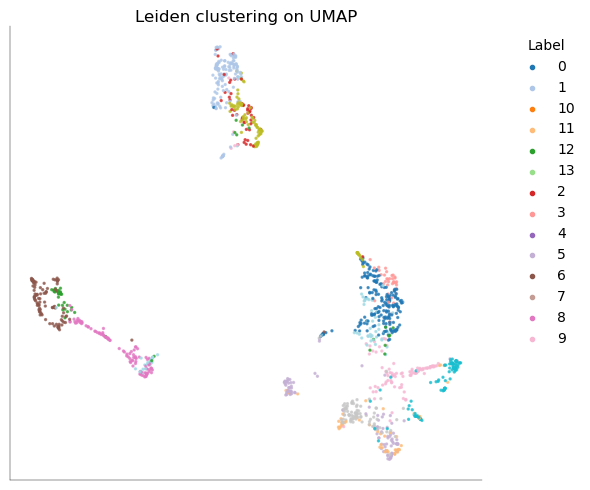

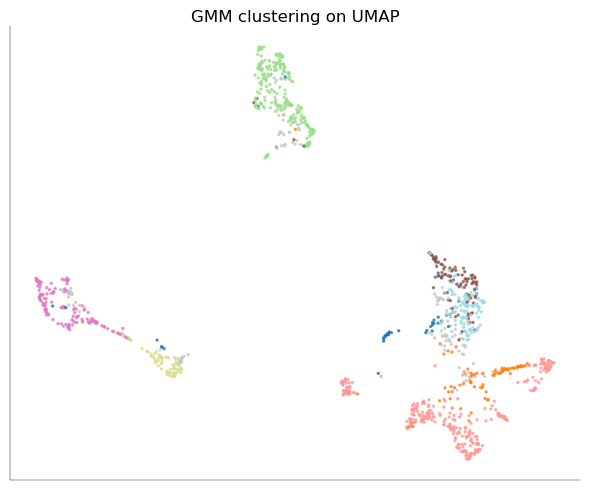

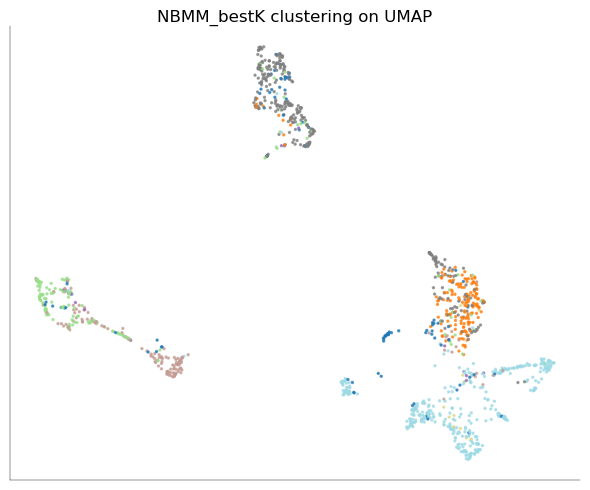

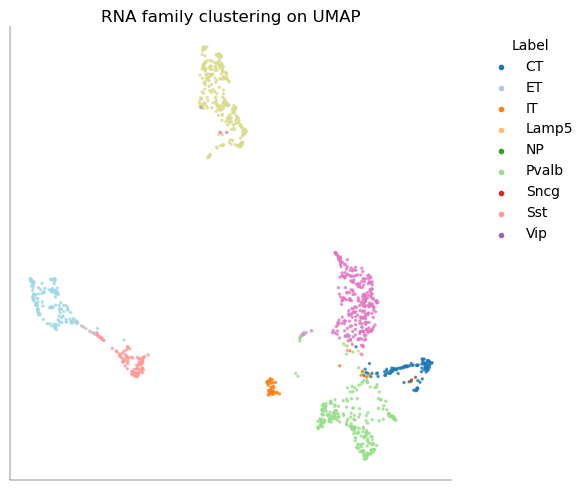

NBMM clustering metrics vs K:
       K       ARI       AMI  Homogeneity  Completeness  Silhouette
0    4.0  0.386834  0.454172     0.384630      0.565089   -0.027414
1    5.0  0.325836  0.416379     0.383704      0.466499   -0.034259
2    6.0  0.382964  0.469160     0.437429      0.518066   -0.038688
3    7.0  0.384195  0.479473     0.462962      0.510062   -0.053409
4    8.0  0.436167  0.510687     0.503373      0.531338   -0.056819
5    9.0  0.317684  0.404145     0.423297      0.402222   -0.049894
6   10.0  0.344998  0.403745     0.417494      0.409036   -0.092530
7   11.0  0.399883  0.456172     0.475411      0.456094   -0.078025
8   12.0  0.354273  0.414618     0.437026      0.413712   -0.070389
9   13.0  0.366624  0.453384     0.496396      0.435507   -0.106223
10  14.0  0.341109  0.415860     0.460184      0.399372   -0.090928
11  15.0  0.325514  0.380190     0.430585      0.363340   -0.088154
12  16.0  0.334548  0.399423     0.465927      0.371467   -0.088723


In [67]:
for name, labels_pred in label_sets.items():
    plt.figure(figsize=(6, 5))
    # If the labels are not integers (e.g., RNA family strings), convert to integer codes for coloring:
    if not np.issubdtype(labels_pred.dtype, np.integer):
        # Map each unique value to a number
        unique_labels, integer_labels = np.unique(
            labels_pred, return_inverse=True
        )
        cvals = integer_labels
        # Optionally build a legend:
        for i, u in enumerate(unique_labels):
            plt.scatter([], [], c=[plt.cm.tab20(i)], label=u)
        plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        cvals = labels_pred

    plt.scatter(
        embedding[:, 0], embedding[:, 1], c=cvals, cmap="tab20", s=8, alpha=0.7
    )
    plt.title(f"{name} clustering on UMAP")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# --- F. Print summary of best NBMM metric per K ---
nbmm_metrics_table = np.array(best_nbmm_metrics)
summary_df = pd.DataFrame(
    nbmm_metrics_table,
    columns=["K", "ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"],
)
print("NBMM clustering metrics vs K:")
print(summary_df)

In [66]:
# Table for NBMM (for all K)
summary_df = pd.DataFrame(
    best_nbmm_metrics,
    columns=["K", "ARI", "AMI", "Homogeneity", "Completeness", "Silhouette"],
)
print("NBMM clustering metrics vs K:")
print(summary_df)

# Table for all methods (best K for NBMM)
compare_dict = {
    "Leiden": leiden_labels,
    "GMM": gmm_labels,
    "NBMM_bestK": nbmm_assignments_per_k[np.argmax(summary_df["AMI"])],
    "RNA_family": rna_family,
}
comparison = []
for name, pred in compare_dict.items():
    row = {"Method": name}
    for metric_name, metric_func in metrics[:-1]:  # all except Silhouette
        row[metric_name] = metric_func(rna_family, pred)
    row["n_clusters"] = len(np.unique(pred))
    comparison.append(row)
df_compare = pd.DataFrame(comparison)
print("\nSummary metrics for clustering methods:")
print(df_compare)

NBMM clustering metrics vs K:
     K       ARI       AMI  Homogeneity  Completeness  Silhouette
0    4  0.386834  0.454172     0.384630      0.565089   -0.027414
1    5  0.325836  0.416379     0.383704      0.466499   -0.034259
2    6  0.382964  0.469160     0.437429      0.518066   -0.038688
3    7  0.384195  0.479473     0.462962      0.510062   -0.053409
4    8  0.436167  0.510687     0.503373      0.531338   -0.056819
5    9  0.317684  0.404145     0.423297      0.402222   -0.049894
6   10  0.344998  0.403745     0.417494      0.409036   -0.092530
7   11  0.399883  0.456172     0.475411      0.456094   -0.078025
8   12  0.354273  0.414618     0.437026      0.413712   -0.070389
9   13  0.366624  0.453384     0.496396      0.435507   -0.106223
10  14  0.341109  0.415860     0.460184      0.399372   -0.090928
11  15  0.325514  0.380190     0.430585      0.363340   -0.088154
12  16  0.334548  0.399423     0.465927      0.371467   -0.088723

Summary metrics for clustering methods:
     

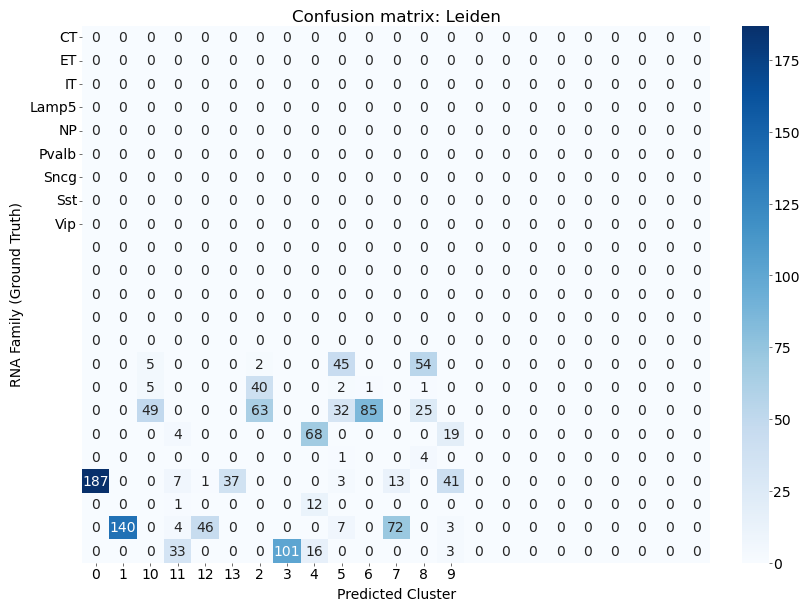

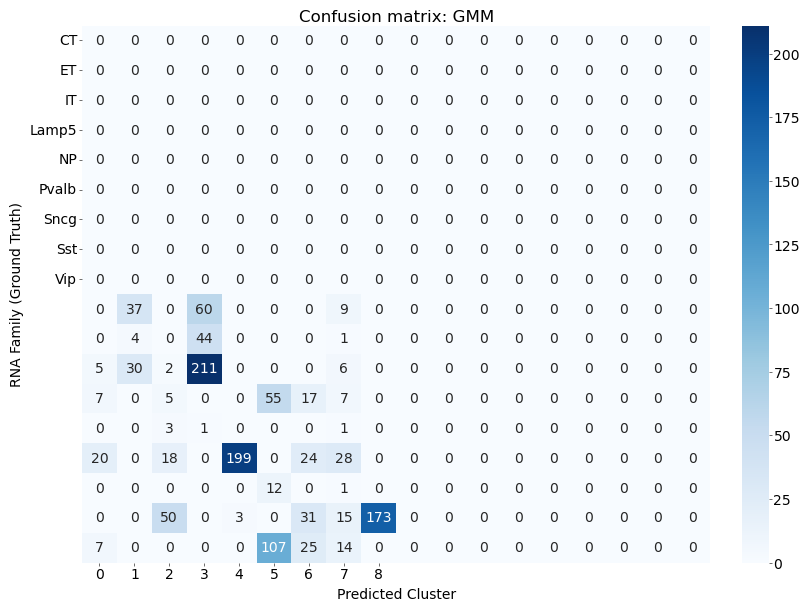

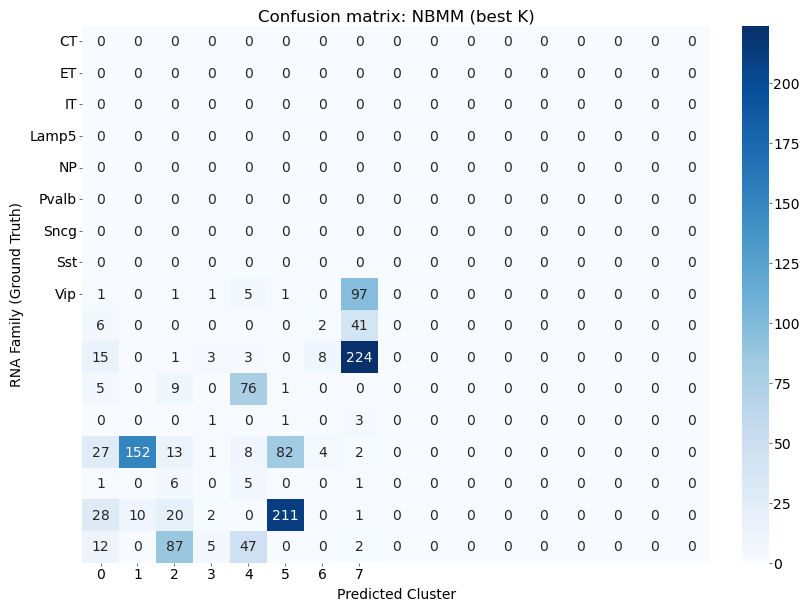

In [ ]:
# Confusion Matrix (Cluster-to-Ground-Truth Heatmap)
from sklearn.metrics import confusion_matrix


def plot_confusion(pred_labels, true_labels, method_name, class_names=None):
    pred_labels_str = np.array(pred_labels).astype(str)
    cm = confusion_matrix(true_labels, pred_labels_str)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=(
            class_names if class_names is not None else np.unique(pred_labels)
        ),
        yticklabels=(
            class_names if class_names is not None else np.unique(true_labels)
        ),
    )
    plt.xlabel("Predicted Cluster")
    plt.ylabel("RNA Family (Ground Truth)")
    plt.title(f"Confusion matrix: {method_name}")
    plt.show()


# For each method:
plot_confusion(leiden_labels, rna_family, "Leiden")
plot_confusion(gmm_labels, rna_family, "GMM")
best_nbmm_labels = nbmm_assignments_per_k[np.argmax(summary_df["AMI"])]
plot_confusion(best_nbmm_labels, rna_family, "NBMM (best K)")

# currently misalignment between ground truth labels and assigned clusters
# fix by passing ground-truth labels for exactly the same cells as for cluster

**5) Correlation between electrophysiological features and genes/PCs.** Finally, connect RNA counts and functional data: Most likely, there will be interesting relationships between the transcriptomic and electrophyiological features in this data. Find these correlations and a way of visualizing them. In studying correlations using the PCA-reduced version of the transcriptomics data, it could be interesting to study PC loadings to see which genes are dominating which PCs. For other advanced analyses, you can get inspitation from Kobak et al., 2021 (https://doi.org/10.1111/rssc.12494).